# Using Deep Learning to Study SUSY with PyTorch

## Learning Goals

The goal of this notebook is to introduce the powerful PyTorch framework for building neural networks and use it to analyze the SUSY dataset. After this notebook, the reader should understand the mechanics of PyTorch and how to construct DNNs using this package. In addition, the reader is encouraged to explore the GPU backend available in Pytorch on this dataset.


## Overview

### Description of Data 

We use Deep Neural Networks to classify the supersymmetry dataset, first introduced by [Baldi et al. in Nature Communication (2015)](https://www.nature.com/articles/ncomms5308). The SUSY data set consists of 5,000,000 Monte-Carlo samples of supersymmetric and non-supersymmetric collisions with  18 features. The signal process is the production of electrically-charged supersymmetric particles which decay to  W bosons and an electrically-neutral supersymmetric particle that is invisible to the detector.

**The first  8 features are "raw" kinematic features that can be directly measured from collisions. The final  10 features are "hand constructed" features** that have been chosen using physical knowledge and are known to be important in distinguishing supersymmetric and non-supersymmetric collision events. More specifically, they are given by the column names below.


**low_features=**\['lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi', 'lepton 2 pT', 'lepton 2 eta', 'lepton 2 phi', 
 'missing energy magnitude', 'missing energy phi'\]

**high_features=**\['MET_rel', 'axial MET', 'M_R', 'M_TR_2', 'R', 'MT2','S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)'\]




From https://archive.ics.uci.edu/ml/datasets/SUSY:  the following image displays the signal (a) vs the background (b): the signal involves an hypotethical supersymmetric particle $\chi^{\pm}$ and $\chi^{0}$ (undetected) along with charged leptons $l^{\pm}$ and neutrinos $\nu$. 
The background process involves $W$ bosons decaying in leptons $l^{\pm}$ and neutrinos $\nu$. In both cases, the resulting observed particles are two charged leptons, since neutrinos and $\chi^{0}$ escape undetected.</br>


<!---![picture]("gdrive/My Drive/ML4HEP_Course/images/SUSY.png")--->

<img src="https://drive.google.com/file/d/1-Brgz5JlUbW3IJut444rpAEK13Nhjh3_">


<!--- #![signal (a) VS background (b)](gdrive/My Drive/ML4HEP_Course/images/SUSY.png)
--->

</br>The classification task requires distinguishing between these two processes and the missing transverse momentum. Simulated events are generated with MADGRAPH event generator assuming 8 TeV collisions of protons at LHC, with showering and hadronization performed by PYTHIA and detector response simulated by DELPHES. 
Notice the masses are set to $m_{\chi^{\pm}}=$ 200 GeV and $m_{\chi^{0}}$ = 100 GeV. 
We focus on fully leptonic decay mode of $W$ bosons, both into $l\nu$ (final state $l\nu l\nu$).

We consider events which satisfy the requirements:
- exactly two electrons or muons each with $p_{\perp}>$ 20 GeV and $|\eta|<$ 2.5
- at least 20 GeV of missing transverse mass 

The basic detector response is used to measure the momentum of each visible particle, basically leptoons, though there may be particle jets induced by radiative processes. 
A critical quantity if the missing transverse momentum $E_{T}$. 

High-level features to select signal vs background (cannot have invariant mass here due to undetected particles):

- **axial $E_{T}$**: missing transverse energy along the vector defined by the charged leptons 

- **transverse mass M_{T2}**: estimating the mass of particles produced in pairs and decaying semi-invisibly [17,18]

- **$E_{T}^{Rel}$**: $E_{T}$ if $\Delta \phi \leq \pi /2$,  $E_{T} \sin{(\Delta\phi)}$ if $\Delta \phi < \pi /2$, where $\Delta\phi$ is the minimum angle between $E_{T}$ and a jet or lepton 

- **razor quantities: $\beta, R$ and $M_{R}$** [19]

- **super-razor quantities $\beta_{R+1}, \cos{(\theta_{R+1}), \Delta\Phi_{R}^{\beta}}, M_{\Delta}^{R}, M_{R}^{T}$ and $\sqrt{\hat{s}_{R}}$** [20]



## Structure and Procedure

Constructing a Deep Neural Network to solve ML problems is a multiple-stage process. Quite generally, one can identify the key steps as follows:
</br>

- step 1: Load and process the data

- step 2: Define the model and its architecture

- step 3: Choose the optimizer and the cost function

- step 4: Train the model

- step 5: Evaluate the model performance on the unseen test data

- step 6: Modify the hyperparameters to optimize performance for the specific data set

</br>
Below, we sometimes combine some of these steps together for convenience.
Notice that we take a rather different approach, compared to the simpler MNIST Keras notebook. We first define a set of classes and functions and run the actual computation only in the very end.

## Load and Process the SUSY Data 

The supersymmetry dataset can be downloaded from the UCI Machine Learning repository on https://archive.ics.uci.edu/ml/machine-learning-databases/00279/SUSY.csv.gz. The dataset is quite large. Download the dataset and unzip it in a directory.


Loading data in Pytroch is done by creating a user-defined class, which we name **SUSY_Dataset**, and is a child of the **torch.utils.data.Dataset** class. This ensures that all necessary attributes required for the processing of the data during the training and test stages are easily inherited. The \_\_init\_\_ method of our custom data class should contain the usual code for loading the data, which is problem-specific, and has been discussed for the SUSY data set in previous notebooks. 

More importantly, the user-defined **data class must override** the **\_\_len\_\_** and **\_\_getitem\_\_** methods of the **parent DataSet class**. The former returns the size of the data set, while the latter allows the user to access a particular data point from the set by specifying its index.

The **\_\_init\_\_()** method bulk-converts all NumPy array data to PyTorch tensors. An alternative is to leave the data in memory as NumPy arrays and then convert to batches of data to tensors in the **\_\_getitem\_\_** method.
The `__getitem___` method is crucial to iterate over the dataset. This is defined in the class SUSY_Dataset, which is eventually inherited by the class `torch.utils.data.DataLoader` that defines `train_loader` and `test_loader`. 

Eventually this allows to loop over the training (testing) data:
`for batch_idx, (data, label) in enumerate(train_loader):`



In [ ]:
from __future__ import print_function, division
import os,sys
import numpy as np
import torch # pytorch package, allows using GPUs

from platform import python_version




print(python_version())

# fix seed
seed=17
np.random.seed(seed)
torch.manual_seed(seed)


#--------------------------------------------------------------------------------------------------
def print_gpu_info():
  print(torch.cuda.current_device(), torch.cuda.device(0), torch.cuda.device_count())
  print(torch.cuda.get_device_name(0), torch.cuda.is_available(), ", cuda: ", torch.version.cuda)


  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
  else:
    print(gpu_info)
#--------------------------------------------------------------------------------------------------

from psutil import virtual_memory

def print_RAM_info():
  ram_gb = virtual_memory().total / 1e9
  print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

  if ram_gb < 20:
    print('Not using a high-RAM runtime')
  else:
    print('You are using a high-RAM runtime!')

#--------------------------------------------------------------------------------------------------

print_gpu_info()
print_RAM_info()



3.7.12
0 <torch.cuda.device object at 0x7f1739ec5b10> 1
Tesla P100-PCIE-16GB True , cuda:  11.1
Tue Dec 21 10:36:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    28W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------

In [ ]:
from torchvision import datasets # load data

class SUSY_Dataset(torch.utils.data.Dataset):  #https://pytorch.org/docs/stable/data.html
    """SUSY pytorch dataset."""

    def __init__(self, data_file, root_dir, dataset_size, train=True, transform=None, high_level_feats=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            train (bool, optional): If set to `True` load training data.
            transform (callable, optional): Optional transform to be applied on a sample.
            high_level_festures (bool, optional): If set to `True`, working with high-level features only. 
                                        If set to `False`, working with low-level features only.
                                        Default is `None`: working with all features
        """

        import pandas as pd

        features=['SUSY','lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi', 'lepton 2 pT', 'lepton 2 eta', 'lepton 2 phi', 
                'missing energy magnitude', 'missing energy phi', 'MET_rel', 'axial MET', 'M_R', 'M_TR_2', 'R', 'MT2', 
                'S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)']

        low_features=['lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi', 'lepton 2 pT', 'lepton 2 eta', 'lepton 2 phi', 
                'missing energy magnitude', 'missing energy phi']

        high_features=['MET_rel', 'axial MET', 'M_R', 'M_TR_2', 'R', 'MT2','S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)']


        #Number of datapoints to work with
        df = pd.read_csv(root_dir+data_file, header=None,nrows=dataset_size,engine='python')
        df.head
        df.columns=features
        Y = df['SUSY']
        X = df[[col for col in df.columns if col!="SUSY"]]

        # set training and test data size
        train_size=int(0.8*dataset_size)
        self.train=train

        if self.train:
            X=X[:train_size]
            Y=Y[:train_size]
            print("Training on {} examples".format(train_size))
        else:
            X=X[train_size:]
            Y=Y[train_size:]
            print("Testing on {} examples".format(dataset_size-train_size))


        self.root_dir = root_dir
        self.transform = transform

        # make datasets using only the 8 low-level features and 10 high-level features
        if high_level_feats is None:
            self.data=(X.values.astype(np.float32),Y.values.astype(int))
            print("Using both high and low level features")
        elif high_level_feats is True:
            self.data=(X[high_features].values.astype(np.float32),Y.values.astype(int))
            print("Using both high-level features only.")
        elif high_level_feats is False:
            self.data=(X[low_features].values.astype(np.float32),Y.values.astype(int))
            print("Using both low-level features only.")


    # override __len__ and __getitem__ of the Dataset() class

    def __len__(self):
        return len(self.data[1])

    def __getitem__(self, idx):

        sample=(self.data[0][idx,...],self.data[1][idx])

        if self.transform:
            sample=self.transform(sample)

        return sample

Last, we define a helper function load_data() that accepts as a required argument the set of parameters args, and returns two generators: test_loader and train_loader which readily return mini-batches.

In [ ]:

def load_data(args):

    from google.colab import drive 
    drive.mount('/content/gdrive')

    #import pandas as pd
    #df_test=pd.read_csv('gdrive/My Drive/ML4HEP_Course/data/datashrunk_SUSY_2.csv')
    
    data_file='SUSY.csv' #'datashrunk_SUSY_2.csv' #'SUSY.csv'
    #root_dir=os.path.expanduser('~')+'/Desktop/ML4HEP/data/'
    root_dir='gdrive/My Drive/ML4HEP_Course/data/'

    kwargs = {} # CUDA arguments, if enabled
    # load and normalise train and test data
    train_loader = torch.utils.data.DataLoader(
        SUSY_Dataset(data_file,root_dir,args.dataset_size,train=True,high_level_feats=args.high_level_feats),
        batch_size=args.batch_size, shuffle=True, **kwargs)

    test_loader = torch.utils.data.DataLoader(
        SUSY_Dataset(data_file,root_dir,args.dataset_size,train=False,high_level_feats=args.high_level_feats),
        batch_size=args.test_batch_size, shuffle=False, **kwargs)

    return train_loader, test_loader


## Step 2: Define the NN Architecture 

To construct neural networks with Pytorch, we make another class called model as a child of `Pytorch's nn.Module`  class. The model class initializes the types of layers needed for the deep neural net in its `__init__` method, while the DNN is assembled in a function method called `forward`, which accepts an `autograd.Variable` object and returns the output layer. Using this convention Pytorch will automatically recognize the structure of the DNN, and the `autograd` module will pull the gradients forward and backward using backprop.

Our code below is constructed in such a way that one can choose whether to use the high-level and low-level features separately and altogether. This choice determines the size of the fully-connected input layer `fc1`. Therefore the `__init__` method accepts the optional argument `high_level_feats`.

In [ ]:
import torch.nn as nn # construct NN

class model(nn.Module):
    def __init__(self,high_level_feats=None):
        # inherit attributes and methods of nn.Module
        super(model, self).__init__()
        #super().__init__()  ##py3 actually only super()

        # an affine operation: y = Wx + b
        # fully connected 
        if high_level_feats is None:
            self.fc1 = nn.Linear(18, 200) # all features
        elif high_level_feats:
            self.fc1 = nn.Linear(10, 200) # low-level only
        else:
            self.fc1 = nn.Linear(8, 200) # high-level only

        # Batch Normalization is a regularization scheme that has been quickly adopted by the neural network 
        # community since its introduction in 2015 (Ioffe 2015)

        self.batchnorm1=nn.BatchNorm1d(200, eps=1e-05, momentum=0.1)
        self.batchnorm2=nn.BatchNorm1d(100, eps=1e-05, momentum=0.1)

        self.fc2 = nn.Linear(200, 100) # see forward function for dimensions
        self.fc3 = nn.Linear(100, 2)
        
        # NOTES
        # All we're doing is just defining values for some layers, we're calling them fc1, fc2...etc, 
        # but you could call them whatever you wanted. The fc just stands for fully connected.
        
        # Each of our nn.Linear layers expects the first parameter to be the input size, 
        # and the 2nd parameter is the output size.
        # So our first layer takes 18 values if we are using all the 18 features.

    def forward(self, x):
        '''Defines the feed-forward function for the NN.

        A backward function is automatically defined using `torch.autograd`

        Parameters
        ----------
        x : autograd.Tensor
            input data

        Returns
        -------
        autograd.Tensor
            output layer of NN

        '''

        # apply rectified linear unit
        x = F.relu(self.fc1(x))
        # apply dropout
        #x=self.batchnorm1(x)
        x = F.dropout(x, training=self.training)


        # apply rectified linear unit
        x = F.relu(self.fc2(x))
        # apply dropout
        #x=self.batchnorm2(x)
        x = F.dropout(x, training=self.training)


        # apply affine operation fc2
        x = self.fc3(x)
        # soft-max layer
        x = F.log_softmax(x,dim=1)

        return x

### Steps 3+4+5: Choose the Optimizer and the Cost Function. Train and Evaluate the Model

Next, we define the function `evaluate_model`. 

- The first argument, `args`, contains all hyperparameters needed for the DNN (see below). 
- The second and third arguments are the `train_loader` and the `test_loader` objects, returned by the function `load_data()` we defined in Step 1 above. The evaluate_model function returns the final `test_loss` and `test_accuracy` of the model.

First, we initialize a model and call the object `DNN`. In order to define the loss function and the optimizer, we use modules `torch.nn.functional` (imported here as F) and `torch.optim`. As a loss function we choose the **negative log-likelihood**, and stored it under the variable criterion. 
As usual, we can choose any from a variety of different SGD-based optimizers, but we focus on the traditional SGD.

Next, we define two functions: `train()` and `test()`. They are called at the end of `evaluate_model` where we loop over the training epochs to train and test our model.

The `train` function accepts an integer called epoch, which is only used to print the training data. We first set the DNN in a train mode using the `train()` method inherited from `nn.Module`. Then we loop over the mini-batches in `train_loader`. We cast the data as pytorch `Variable`, re-set the `optimizer`, perform the forward step by calling the DNN model on the data and computing the loss. The backprop algorithm is then easily done using the `backward()` method of the loss function criterion. We use `optimizer.step` to update the weights of the DNN. Last print the performance for every minibatch. `train` returns the loss on the data.

The `test` function is similar to train but its purpose is to test the performance of a trained model. Once we set the DNN model in `eval()` mode, the following steps are similar to those in train. We then compute the `test_loss` and the number of correct predictions, print the results and return them.

Notice the `DataLoader` class is designed so that it can be iterated using the enumerate() function, which returns a tuple with the current batch zero-based index value, and the actual batch of data. 

In [ ]:
import torch.nn.functional as F # implements forward and backward definitions of an autograd operation
import torch.optim as optim # different update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc

from tqdm import tqdm 
from tqdm import trange 
from time import sleep



def evaluate_model(args,train_loader,test_loader):
    
    
    
    device = torch.device("cuda" if args.no_cuda else "cpu")


    # create model
    DNN = model(high_level_feats=args.high_level_feats).to(device) 

    # negative log-likelihood (nll) loss for training: takes class labels NOT one-hot vectors!
    criterion = F.nll_loss
    # define SGD optimizer
    optimizer = optim.SGD(DNN.parameters(), lr=args.lr, momentum=args.momentum)
    #optimizer = optim.Adam(DNN.parameters(), lr=0.001, betas=(0.9, 0.999))

    
    
    
    ################################################

    def train(epoch, device):
        '''Trains a NN using minibatches.

        Parameters
        ----------
        epoch : int
            Training epoch number.

        '''

        # set model to training mode (affects Dropout and BatchNorm)
        DNN.train()
        
       
        
        # to handle stream 
        with tqdm(train_loader, unit="batch") as tepoch:
        
            # loop over training data
            #for batch_idx, (data, label) in enumerate(train_loader):
            for batch_idx, (data, label) in enumerate(tepoch):
                
                tepoch.set_description(f"Epoch {epoch}")
                
                data, label = data.to(device), label.to(device)
                
                # zero gradient buffers
                optimizer.zero_grad()
                # compute output of final layer: forward step
                output = DNN(data)
                # compute loss
                loss = criterion(output, label)
                # run backprop: backward step
                loss.backward()
                # update weigths of NN
                optimizer.step()

                # print loss at current epoch
                if batch_idx % args.log_interval == 0:
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch, batch_idx * len(data), len(train_loader.dataset),
                        100. * batch_idx / len(train_loader), loss.item() ))


                # difference between len(train_loader.dataset) and len(train_loader)

                tepoch.set_postfix(loss=loss.item())
                sleep(0.1)
                
            return loss.item()     
    
    
        
        
    ################################################

    def test(device):
        '''Tests NN performance.

        '''

        # evaluate model
        DNN.eval() 

        # model.eval() is a kind of switch for some specific layers/parts of the model that behave differently during training and inference (evaluating) time. 
        # For example, Dropouts Layers, BatchNorm Layers etc. 
        # You need to turn off them during model evaluation, and .eval() will do it for you. 
        # In addition, the common practice for evaluating/validation is to turn off gradients computation 


        test_loss = 0 # loss function on test data
        correct = 0 # number of correct predictions
        # loop over test data
        store_output = []
        #store_output = None 

        for data, label in test_loader:

            #print("data: ", data.shape, data.dtype)
            #print("labels: ", label.shape, label.dtype)
            #print("")
            # compute model prediction softmax probability
            
            data, label = data.to(device), label.to(device)
            
            output = DNN(data)
            # compute test loss
            test_loss += criterion(output, label, size_average=False).item() # sum up batch loss
            # find most likely prediction

            store_output.append(output.data) # (batch_size,2) tensors of (log(p),log(q)) 
            #store_output = output.data  # overwrite: remember you just need at the last epoch... 
            #print("output: ", store_output.shape, store_output.dtype) 

            #print("\n\n")
            #print(store_output[: 10])

            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            #print("")
            #print(pred[: 10])

            # If keepdim is True, the output tensors are of the same size as input except in the dimension dim where they are of size 1. 
            # Otherwise, dim is squeezed (see torch.squeeze()), resulting in the output tensors having 1 fewer dimension than input.

            # update number of correct predictions (https://pytorch.org/docs/stable/generated/torch.eq.html element-wise equality)
            # other. self.view_as(other) is equivalent to self.view(other.size())
            correct += pred.eq(label.data.view_as(pred)).cpu().sum().item()   #sum over booleans, item returns the value 
            # This is used to move the tensor to cpu(). 
            # Some operations on tensors cannot be performed on cuda tensors so you need to move them to cpu first.

        # print test loss
        test_loss /= len(test_loader.dataset)
        
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
        
        
        stdata = store_output[0]

        for i in range(len(store_output)):
          tmpd = store_output[i]
          if i>0:
            stdata = torch.cat((stdata,tmpd))
        

        return test_loss, correct / len(test_loader.dataset), store_output #stdata
    
    ################################################


    train_loss=np.zeros((args.epochs,))
    test_loss=np.zeros_like(train_loss)
    test_accuracy=np.zeros_like(train_loss)
    test_output = []
    

    epochs=range(1, args.epochs + 1)
    for epoch in epochs:

        train_loss[epoch-1] = train(epoch, device)
        test_loss[epoch-1], test_accuracy[epoch-1], _ = test(device)
        test_output.append(_)



    outl = []
    outl.append(test_loss[-1])
    outl.append(test_accuracy[-1])
    outl.append(train_loss)
    outl.append(test_loss)

    if(args.load_model):
      #outl.append(DNN)
      outl.append(test_output[-1]) #passing the last epoch test_output data 


    #return test_loss[-1], test_accuracy[-1], train_loss, test_loss     
    return outl 

### Step 6: Modify the Hyperparameters to Optimize Performance of the Model¶

To study the performance of the model for a variety of different `data_set_sizes` and `learning_rates`, we do a grid search.
Let us define a function grid_search, which accepts the args variable containing all hyper-parameters needed for the problem. After choosing logarithmically-spaced `data_set_sizes` and `learning_rates`, we first loop over all `data_set_sizes`, update the args variable, and call the `load_data` function. We then loop once again over all `learning_rates`, update args and call `evaluate_model`.

In [ ]:
# -------- no need to rerun a grid search ---- take max learning curve and dataset from exercise part1 

"""
def grid_search(args):


    # perform grid search over learnign rate and number of hidden neurons
    dataset_sizes=[10000, 100000] #np.logspace(2,5,4).astype('int')
    learning_rates=np.logspace(-5,-1,3)

    # pre-alocate data
    test_loss=np.zeros((len(dataset_sizes),len(learning_rates)),dtype=np.float64)
    test_accuracy=np.zeros_like(test_loss)

    # do grid search
    for i, dataset_size in enumerate(dataset_sizes):
        # upate data set size parameters
        args.dataset_size=dataset_size
        args.batch_size=int(0.01*dataset_size)

        # load data
        train_loader, test_loader = load_data(args)

        for j, lr in enumerate(learning_rates):
            # update learning rate
            args.lr=lr

            print("\n training DNN with %5d data points and SGD lr=%0.6f. \n" %(dataset_size,lr) )

            test_loss[i,j],test_accuracy[i,j] = evaluate_model(args,train_loader,test_loader)


    plot_data(learning_rates,dataset_sizes,test_accuracy)
    
"""    

'\ndef grid_search(args):\n\n\n    # perform grid search over learnign rate and number of hidden neurons\n    dataset_sizes=[10000, 100000] #np.logspace(2,5,4).astype(\'int\')\n    learning_rates=np.logspace(-5,-1,3)\n\n    # pre-alocate data\n    test_loss=np.zeros((len(dataset_sizes),len(learning_rates)),dtype=np.float64)\n    test_accuracy=np.zeros_like(test_loss)\n\n    # do grid search\n    for i, dataset_size in enumerate(dataset_sizes):\n        # upate data set size parameters\n        args.dataset_size=dataset_size\n        args.batch_size=int(0.01*dataset_size)\n\n        # load data\n        train_loader, test_loader = load_data(args)\n\n        for j, lr in enumerate(learning_rates):\n            # update learning rate\n            args.lr=lr\n\n            print("\n training DNN with %5d data points and SGD lr=%0.6f. \n" %(dataset_size,lr) )\n\n            test_loss[i,j],test_accuracy[i,j] = evaluate_model(args,train_loader,test_loader)\n\n\n    plot_data(learning_rates,da

In [ ]:
def run_optimal(args):

  # use optimal pars
  dataset_size = 10000 #or more 
  lr = 0.1

  #args.dataset_size=dataset_size
  args.batch_size=int(0.01*dataset_size)

  # load data
  train_loader, test_loader = load_data(args)

  #args.lr=lr

  print("\n training DNN with %5d data points and SGD lr=%0.6f. \n" %(dataset_size,lr) )

  #test_loss,test_accuracy, arr_loss, arr_accuracy = evaluate_model(args,train_loader,test_loader)

  outl =  evaluate_model(args,train_loader,test_loader) 
  test_loss = outl[0]
  test_accuracy = outl[1]
  arr_train_loss  = outl[2]
  arr_test_loss = outl[3]

  #ores = [test_loss,test_accuracy, arr_loss, arr_accuracy]

  #ores = outl[: 4]

  return outl, test_loader


Last, we use the function `plot_data`, defined below, to plot the results.

In [ ]:
import matplotlib.pyplot as plt

def plot_data(x,y,data):

    # plot results
    fontsize=16


    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(data, interpolation='nearest', vmin=0, vmax=1)
    
    cbar=fig.colorbar(cax)
    cbar.ax.set_ylabel('accuracy (%)',rotation=90,fontsize=fontsize)
    cbar.set_ticks([0,.2,.4,0.6,0.8,1.0])
    cbar.set_ticklabels(['0%','20%','40%','60%','80%','100%'])

    # put text on matrix elements
    for i, x_val in enumerate(np.arange(len(x))):
        for j, y_val in enumerate(np.arange(len(y))):
            c = "${0:.1f}\\%$".format( 100*data[j,i])  
            ax.text(x_val, y_val, c, va='center', ha='center')

    # convert axis vaues to to string labels
    x=[str(i) for i in x]
    y=[str(i) for i in y]


    ax.set_xticklabels(['']+x)
    ax.set_yticklabels(['']+y)

    ax.set_xlabel('$\\mathrm{learning\\ rate}$',fontsize=fontsize)
    ax.set_ylabel('$\\mathrm{hidden\\ neurons}$',fontsize=fontsize)

    plt.tight_layout()

    plt.show()

### Run Code

As we mentioned in the beginning of the notebook, all functions and classes discussed above only specify the procedure but do not actually perform any computations. This allows us to re-use them for different problems.

Actually running the training and testing for every point in the grid search is done below. The `argparse` class allows us to conveniently keep track of all hyperparameters, stored in the variable `args` which enters most of the functions we defined above.

To run the simulation, we call the function `grid_search`.

# Exercises

### GPU and CUDA

One of the advantages of Pytorch is that it allows to automatically use the CUDA library for fast performance on GPU's. For the sake of clarity, we have omitted this in the above notebook. Go online to check how to put the CUDA commands back into the code above. Hint: study the [Pytorch MNIST tutorial](https://github.com/pytorch/examples/blob/master/mnist/main.py) to see how this works in practice.

In [ ]:
import argparse # handles arguments
import sys; sys.argv=['']; del sys # required to use parser in jupyter notebooks

# Training settings
parser = argparse.ArgumentParser(description='PyTorch SUSY Example')
parser.add_argument('--dataset_size', type=int, default=100000, metavar='DS',
                help='size of data set (default: 100000)')
parser.add_argument('--high_level_feats', type=bool, default=None, metavar='HLF',
                help='toggles high level features (default: None)')
parser.add_argument('--batch-size', type=int, default=100, metavar='N',
                help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                help='number of epochs to train (default: 10)')
parser.add_argument('--lr', type=float, default=0.05, metavar='LR',
                help='learning rate (default: 0.02)')
parser.add_argument('--momentum', type=float, default=0.8, metavar='M',
                help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=True,
                help='disables CUDA training')
parser.add_argument('--load_model', action='store_false', default=True,
                help='load trained model')
parser.add_argument('--seed', type=int, default=2, metavar='S',
                help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                help='how many batches to wait before logging training status')
args = parser.parse_args()


"""
# set seed of random number generator
torch.manual_seed(args.seed)


grid_search(args)
"""

#-------- run optimized

args.lr = 0.1 
args.dataset_size = 100000
args.epochs = 10
lres, loaded_testdata = run_optimal(args)

Mounted at /content/gdrive
Training on 80000 examples
Using both high and low level features
Testing on 20000 examples
Using both high and low level features

 training DNN with 10000 data points and SGD lr=0.100000. 



Epoch 1:   0%|          | 1/800 [00:00<03:15,  4.09batch/s, loss=0.671]

Train Epoch: 1 [0/80000 (0%)]	Loss: 0.696872


Epoch 1:   1%|▏         | 11/800 [00:01<01:27,  9.05batch/s, loss=0.631]

Train Epoch: 1 [1000/80000 (1%)]	Loss: 0.637690


Epoch 1:   3%|▎         | 21/800 [00:02<01:24,  9.19batch/s, loss=0.59] 

Train Epoch: 1 [2000/80000 (2%)]	Loss: 0.584255


Epoch 1:   4%|▍         | 31/800 [00:03<01:23,  9.25batch/s, loss=0.58] 

Train Epoch: 1 [3000/80000 (4%)]	Loss: 0.508652


Epoch 1:   5%|▌         | 41/800 [00:04<01:22,  9.24batch/s, loss=0.515]

Train Epoch: 1 [4000/80000 (5%)]	Loss: 0.536835


Epoch 1:   6%|▋         | 51/800 [00:05<01:21,  9.14batch/s, loss=0.51]

Train Epoch: 1 [5000/80000 (6%)]	Loss: 0.630269


Epoch 1:   8%|▊         | 61/800 [00:06<01:20,  9.20batch/s, loss=0.447]

Train Epoch: 1 [6000/80000 (8%)]	Loss: 0.569512


Epoch 1:   9%|▉         | 71/800 [00:07<01:19,  9.22batch/s, loss=0.47]

Train Epoch: 1 [7000/80000 (9%)]	Loss: 0.429670


Epoch 1:  10%|█         | 81/800 [00:08<01:17,  9.25batch/s, loss=0.545]

Train Epoch: 1 [8000/80000 (10%)]	Loss: 0.502775


Epoch 1:  11%|█▏        | 91/800 [00:10<01:16,  9.24batch/s, loss=0.545]

Train Epoch: 1 [9000/80000 (11%)]	Loss: 0.547685


Epoch 1:  13%|█▎        | 101/800 [00:11<01:15,  9.25batch/s, loss=0.469]

Train Epoch: 1 [10000/80000 (12%)]	Loss: 0.531347


Epoch 1:  14%|█▍        | 111/800 [00:12<01:14,  9.28batch/s, loss=0.453]

Train Epoch: 1 [11000/80000 (14%)]	Loss: 0.591175


Epoch 1:  15%|█▌        | 121/800 [00:13<01:13,  9.23batch/s, loss=0.501]

Train Epoch: 1 [12000/80000 (15%)]	Loss: 0.409194


Epoch 1:  16%|█▋        | 131/800 [00:14<01:11,  9.30batch/s, loss=0.513]

Train Epoch: 1 [13000/80000 (16%)]	Loss: 0.494373


Epoch 1:  18%|█▊        | 141/800 [00:15<01:10,  9.32batch/s, loss=0.543]

Train Epoch: 1 [14000/80000 (18%)]	Loss: 0.525495


Epoch 1:  19%|█▉        | 151/800 [00:16<01:09,  9.31batch/s, loss=0.458]

Train Epoch: 1 [15000/80000 (19%)]	Loss: 0.493300


Epoch 1:  20%|██        | 161/800 [00:17<01:08,  9.29batch/s, loss=0.69] 

Train Epoch: 1 [16000/80000 (20%)]	Loss: 0.482108


Epoch 1:  21%|██▏       | 171/800 [00:18<01:07,  9.29batch/s, loss=0.464]

Train Epoch: 1 [17000/80000 (21%)]	Loss: 0.591422


Epoch 1:  23%|██▎       | 181/800 [00:19<01:06,  9.27batch/s, loss=0.486]

Train Epoch: 1 [18000/80000 (22%)]	Loss: 0.424896


Epoch 1:  24%|██▍       | 191/800 [00:20<01:05,  9.28batch/s, loss=0.413]

Train Epoch: 1 [19000/80000 (24%)]	Loss: 0.441462


Epoch 1:  25%|██▌       | 201/800 [00:21<01:04,  9.28batch/s, loss=0.438]

Train Epoch: 1 [20000/80000 (25%)]	Loss: 0.481353


Epoch 1:  26%|██▋       | 211/800 [00:22<01:03,  9.29batch/s, loss=0.432]

Train Epoch: 1 [21000/80000 (26%)]	Loss: 0.432998


Epoch 1:  28%|██▊       | 221/800 [00:24<01:02,  9.19batch/s, loss=0.499]

Train Epoch: 1 [22000/80000 (28%)]	Loss: 0.502731


Epoch 1:  29%|██▉       | 231/800 [00:25<01:01,  9.27batch/s, loss=0.498]

Train Epoch: 1 [23000/80000 (29%)]	Loss: 0.566545


Epoch 1:  30%|███       | 241/800 [00:26<01:00,  9.30batch/s, loss=0.552]

Train Epoch: 1 [24000/80000 (30%)]	Loss: 0.385426


Epoch 1:  31%|███▏      | 251/800 [00:27<00:59,  9.26batch/s, loss=0.396]

Train Epoch: 1 [25000/80000 (31%)]	Loss: 0.460340


Epoch 1:  33%|███▎      | 261/800 [00:28<00:57,  9.30batch/s, loss=0.486]

Train Epoch: 1 [26000/80000 (32%)]	Loss: 0.481504


Epoch 1:  34%|███▍      | 271/800 [00:29<00:56,  9.31batch/s, loss=0.458]

Train Epoch: 1 [27000/80000 (34%)]	Loss: 0.428223


Epoch 1:  35%|███▌      | 281/800 [00:30<00:55,  9.31batch/s, loss=0.568]

Train Epoch: 1 [28000/80000 (35%)]	Loss: 0.495873


Epoch 1:  36%|███▋      | 291/800 [00:31<00:54,  9.29batch/s, loss=0.446]

Train Epoch: 1 [29000/80000 (36%)]	Loss: 0.425268


Epoch 1:  38%|███▊      | 301/800 [00:32<00:53,  9.26batch/s, loss=0.414]

Train Epoch: 1 [30000/80000 (38%)]	Loss: 0.409179


Epoch 1:  39%|███▉      | 311/800 [00:33<00:52,  9.26batch/s, loss=0.541]

Train Epoch: 1 [31000/80000 (39%)]	Loss: 0.436164


Epoch 1:  40%|████      | 321/800 [00:34<00:51,  9.30batch/s, loss=0.621]

Train Epoch: 1 [32000/80000 (40%)]	Loss: 0.485391


Epoch 1:  41%|████▏     | 331/800 [00:35<00:50,  9.27batch/s, loss=0.472]

Train Epoch: 1 [33000/80000 (41%)]	Loss: 0.514698


Epoch 1:  43%|████▎     | 341/800 [00:36<00:49,  9.25batch/s, loss=0.48] 

Train Epoch: 1 [34000/80000 (42%)]	Loss: 0.505765


Epoch 1:  44%|████▍     | 351/800 [00:37<00:48,  9.30batch/s, loss=0.395]

Train Epoch: 1 [35000/80000 (44%)]	Loss: 0.504492


Epoch 1:  45%|████▌     | 361/800 [00:39<00:47,  9.29batch/s, loss=0.392]

Train Epoch: 1 [36000/80000 (45%)]	Loss: 0.642316


Epoch 1:  46%|████▋     | 371/800 [00:40<00:46,  9.29batch/s, loss=0.481]

Train Epoch: 1 [37000/80000 (46%)]	Loss: 0.465264


Epoch 1:  48%|████▊     | 381/800 [00:41<00:45,  9.26batch/s, loss=0.484]

Train Epoch: 1 [38000/80000 (48%)]	Loss: 0.404963


Epoch 1:  49%|████▉     | 391/800 [00:42<00:43,  9.31batch/s, loss=0.432]

Train Epoch: 1 [39000/80000 (49%)]	Loss: 0.485976


Epoch 1:  50%|█████     | 401/800 [00:43<00:42,  9.29batch/s, loss=0.55] 

Train Epoch: 1 [40000/80000 (50%)]	Loss: 0.497229


Epoch 1:  51%|█████▏    | 411/800 [00:44<00:41,  9.30batch/s, loss=0.411]

Train Epoch: 1 [41000/80000 (51%)]	Loss: 0.517172


Epoch 1:  53%|█████▎    | 421/800 [00:45<00:40,  9.24batch/s, loss=0.483]

Train Epoch: 1 [42000/80000 (52%)]	Loss: 0.463395


Epoch 1:  54%|█████▍    | 431/800 [00:46<00:39,  9.27batch/s, loss=0.538]

Train Epoch: 1 [43000/80000 (54%)]	Loss: 0.511927


Epoch 1:  55%|█████▌    | 441/800 [00:47<00:38,  9.29batch/s, loss=0.46] 

Train Epoch: 1 [44000/80000 (55%)]	Loss: 0.594948


Epoch 1:  56%|█████▋    | 451/800 [00:48<00:37,  9.30batch/s, loss=0.397]

Train Epoch: 1 [45000/80000 (56%)]	Loss: 0.541279


Epoch 1:  58%|█████▊    | 461/800 [00:49<00:36,  9.30batch/s, loss=0.428]

Train Epoch: 1 [46000/80000 (58%)]	Loss: 0.459197


Epoch 1:  59%|█████▉    | 471/800 [00:50<00:35,  9.20batch/s, loss=0.426]

Train Epoch: 1 [47000/80000 (59%)]	Loss: 0.351348


Epoch 1:  60%|██████    | 481/800 [00:51<00:34,  9.26batch/s, loss=0.424]

Train Epoch: 1 [48000/80000 (60%)]	Loss: 0.528151


Epoch 1:  61%|██████▏   | 491/800 [00:53<00:33,  9.28batch/s, loss=0.553]

Train Epoch: 1 [49000/80000 (61%)]	Loss: 0.515042


Epoch 1:  63%|██████▎   | 501/800 [00:54<00:32,  9.29batch/s, loss=0.438]

Train Epoch: 1 [50000/80000 (62%)]	Loss: 0.450032


Epoch 1:  64%|██████▍   | 511/800 [00:55<00:31,  9.31batch/s, loss=0.593]

Train Epoch: 1 [51000/80000 (64%)]	Loss: 0.476084


Epoch 1:  65%|██████▌   | 521/800 [00:56<00:30,  9.21batch/s, loss=0.414]

Train Epoch: 1 [52000/80000 (65%)]	Loss: 0.424349


Epoch 1:  66%|██████▋   | 531/800 [00:57<00:28,  9.29batch/s, loss=0.446]

Train Epoch: 1 [53000/80000 (66%)]	Loss: 0.460354


Epoch 1:  68%|██████▊   | 541/800 [00:58<00:28,  9.24batch/s, loss=0.574]

Train Epoch: 1 [54000/80000 (68%)]	Loss: 0.549952


Epoch 1:  69%|██████▉   | 551/800 [00:59<00:26,  9.26batch/s, loss=0.459]

Train Epoch: 1 [55000/80000 (69%)]	Loss: 0.438042


Epoch 1:  70%|███████   | 561/800 [01:00<00:25,  9.30batch/s, loss=0.491]

Train Epoch: 1 [56000/80000 (70%)]	Loss: 0.394889


Epoch 1:  71%|███████▏  | 571/800 [01:01<00:24,  9.29batch/s, loss=0.496]

Train Epoch: 1 [57000/80000 (71%)]	Loss: 0.457434


Epoch 1:  73%|███████▎  | 581/800 [01:02<00:23,  9.28batch/s, loss=0.522]

Train Epoch: 1 [58000/80000 (72%)]	Loss: 0.414643


Epoch 1:  74%|███████▍  | 591/800 [01:03<00:22,  9.31batch/s, loss=0.576]

Train Epoch: 1 [59000/80000 (74%)]	Loss: 0.507251


Epoch 1:  75%|███████▌  | 601/800 [01:04<00:21,  9.31batch/s, loss=0.421]

Train Epoch: 1 [60000/80000 (75%)]	Loss: 0.521891


Epoch 1:  76%|███████▋  | 611/800 [01:05<00:20,  9.31batch/s, loss=0.481]

Train Epoch: 1 [61000/80000 (76%)]	Loss: 0.480636


Epoch 1:  78%|███████▊  | 621/800 [01:07<00:19,  9.23batch/s, loss=0.431]

Train Epoch: 1 [62000/80000 (78%)]	Loss: 0.442173


Epoch 1:  79%|███████▉  | 631/800 [01:08<00:18,  9.28batch/s, loss=0.443]

Train Epoch: 1 [63000/80000 (79%)]	Loss: 0.425038


Epoch 1:  80%|████████  | 641/800 [01:09<00:17,  9.30batch/s, loss=0.489]

Train Epoch: 1 [64000/80000 (80%)]	Loss: 0.460000


Epoch 1:  81%|████████▏ | 651/800 [01:10<00:16,  9.20batch/s, loss=0.384]

Train Epoch: 1 [65000/80000 (81%)]	Loss: 0.537868


Epoch 1:  83%|████████▎ | 661/800 [01:11<00:15,  9.24batch/s, loss=0.496]

Train Epoch: 1 [66000/80000 (82%)]	Loss: 0.471552


Epoch 1:  84%|████████▍ | 671/800 [01:12<00:13,  9.26batch/s, loss=0.416]

Train Epoch: 1 [67000/80000 (84%)]	Loss: 0.444018


Epoch 1:  85%|████████▌ | 681/800 [01:13<00:12,  9.27batch/s, loss=0.632]

Train Epoch: 1 [68000/80000 (85%)]	Loss: 0.460665


Epoch 1:  86%|████████▋ | 691/800 [01:14<00:11,  9.23batch/s, loss=0.377]

Train Epoch: 1 [69000/80000 (86%)]	Loss: 0.444786


Epoch 1:  88%|████████▊ | 701/800 [01:15<00:10,  9.28batch/s, loss=0.501]

Train Epoch: 1 [70000/80000 (88%)]	Loss: 0.452040


Epoch 1:  89%|████████▉ | 711/800 [01:16<00:09,  9.30batch/s, loss=0.495]

Train Epoch: 1 [71000/80000 (89%)]	Loss: 0.529605


Epoch 1:  90%|█████████ | 721/800 [01:17<00:08,  9.28batch/s, loss=0.528]

Train Epoch: 1 [72000/80000 (90%)]	Loss: 0.356945


Epoch 1:  91%|█████████▏| 731/800 [01:18<00:07,  9.28batch/s, loss=0.398]

Train Epoch: 1 [73000/80000 (91%)]	Loss: 0.587349


Epoch 1:  93%|█████████▎| 741/800 [01:20<00:06,  9.29batch/s, loss=0.484]

Train Epoch: 1 [74000/80000 (92%)]	Loss: 0.465721


Epoch 1:  94%|█████████▍| 751/800 [01:21<00:05,  9.32batch/s, loss=0.421]

Train Epoch: 1 [75000/80000 (94%)]	Loss: 0.425689


Epoch 1:  95%|█████████▌| 761/800 [01:22<00:04,  9.30batch/s, loss=0.453]

Train Epoch: 1 [76000/80000 (95%)]	Loss: 0.454428


Epoch 1:  96%|█████████▋| 771/800 [01:23<00:03,  9.30batch/s, loss=0.491]

Train Epoch: 1 [77000/80000 (96%)]	Loss: 0.319693


Epoch 1:  98%|█████████▊| 781/800 [01:24<00:02,  9.23batch/s, loss=0.414]

Train Epoch: 1 [78000/80000 (98%)]	Loss: 0.423996


Epoch 1:  99%|█████████▉| 791/800 [01:25<00:00,  9.27batch/s, loss=0.394]

Train Epoch: 1 [79000/80000 (99%)]	Loss: 0.527345


Epoch 1: 100%|██████████| 800/800 [01:26<00:00,  9.26batch/s, loss=0.455]
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.4542, Accuracy: 15807/20000 (79.035%)



Epoch 2:   0%|          | 1/800 [00:00<01:29,  8.93batch/s, loss=0.466]

Train Epoch: 2 [0/80000 (0%)]	Loss: 0.441667


Epoch 2:   1%|▏         | 11/800 [00:01<01:24,  9.30batch/s, loss=0.496]

Train Epoch: 2 [1000/80000 (1%)]	Loss: 0.355160


Epoch 2:   3%|▎         | 21/800 [00:02<01:23,  9.28batch/s, loss=0.419]

Train Epoch: 2 [2000/80000 (2%)]	Loss: 0.372035


Epoch 2:   4%|▍         | 31/800 [00:03<01:22,  9.31batch/s, loss=0.478]

Train Epoch: 2 [3000/80000 (4%)]	Loss: 0.433049


Epoch 2:   5%|▌         | 41/800 [00:04<01:21,  9.27batch/s, loss=0.42] 

Train Epoch: 2 [4000/80000 (5%)]	Loss: 0.486554


Epoch 2:   6%|▋         | 51/800 [00:05<01:20,  9.30batch/s, loss=0.506]

Train Epoch: 2 [5000/80000 (6%)]	Loss: 0.399902


Epoch 2:   8%|▊         | 61/800 [00:06<01:19,  9.32batch/s, loss=0.424]

Train Epoch: 2 [6000/80000 (8%)]	Loss: 0.416628


Epoch 2:   9%|▉         | 71/800 [00:07<01:18,  9.32batch/s, loss=0.498]

Train Epoch: 2 [7000/80000 (9%)]	Loss: 0.349813


Epoch 2:  10%|█         | 81/800 [00:08<01:17,  9.30batch/s, loss=0.44] 

Train Epoch: 2 [8000/80000 (10%)]	Loss: 0.377284


Epoch 2:  11%|█▏        | 91/800 [00:09<01:16,  9.25batch/s, loss=0.387]

Train Epoch: 2 [9000/80000 (11%)]	Loss: 0.470495


Epoch 2:  13%|█▎        | 101/800 [00:10<01:15,  9.25batch/s, loss=0.435]

Train Epoch: 2 [10000/80000 (12%)]	Loss: 0.415995


Epoch 2:  14%|█▍        | 111/800 [00:11<01:14,  9.29batch/s, loss=0.484]

Train Epoch: 2 [11000/80000 (14%)]	Loss: 0.474950


Epoch 2:  15%|█▌        | 121/800 [00:13<01:12,  9.33batch/s, loss=0.528]

Train Epoch: 2 [12000/80000 (15%)]	Loss: 0.492939


Epoch 2:  16%|█▋        | 131/800 [00:14<01:12,  9.23batch/s, loss=0.529]

Train Epoch: 2 [13000/80000 (16%)]	Loss: 0.473201


Epoch 2:  18%|█▊        | 141/800 [00:15<01:10,  9.32batch/s, loss=0.469]

Train Epoch: 2 [14000/80000 (18%)]	Loss: 0.464999


Epoch 2:  19%|█▉        | 151/800 [00:16<01:09,  9.32batch/s, loss=0.487]

Train Epoch: 2 [15000/80000 (19%)]	Loss: 0.469086


Epoch 2:  20%|██        | 161/800 [00:17<01:09,  9.22batch/s, loss=0.475]

Train Epoch: 2 [16000/80000 (20%)]	Loss: 0.396496


Epoch 2:  21%|██▏       | 171/800 [00:18<01:07,  9.28batch/s, loss=0.402]

Train Epoch: 2 [17000/80000 (21%)]	Loss: 0.464197


Epoch 2:  23%|██▎       | 181/800 [00:19<01:06,  9.30batch/s, loss=0.418]

Train Epoch: 2 [18000/80000 (22%)]	Loss: 0.413292


Epoch 2:  24%|██▍       | 191/800 [00:20<01:05,  9.24batch/s, loss=0.521]

Train Epoch: 2 [19000/80000 (24%)]	Loss: 0.436478


Epoch 2:  25%|██▌       | 201/800 [00:21<01:04,  9.25batch/s, loss=0.523]

Train Epoch: 2 [20000/80000 (25%)]	Loss: 0.437732


Epoch 2:  26%|██▋       | 211/800 [00:22<01:03,  9.28batch/s, loss=0.503]

Train Epoch: 2 [21000/80000 (26%)]	Loss: 0.468449


Epoch 2:  28%|██▊       | 221/800 [00:23<01:02,  9.23batch/s, loss=0.518]

Train Epoch: 2 [22000/80000 (28%)]	Loss: 0.472048


Epoch 2:  29%|██▉       | 231/800 [00:24<01:01,  9.30batch/s, loss=0.364]

Train Epoch: 2 [23000/80000 (29%)]	Loss: 0.356188


Epoch 2:  30%|███       | 241/800 [00:25<01:00,  9.23batch/s, loss=0.497]

Train Epoch: 2 [24000/80000 (30%)]	Loss: 0.524103


Epoch 2:  31%|███▏      | 251/800 [00:27<00:59,  9.19batch/s, loss=0.47] 

Train Epoch: 2 [25000/80000 (31%)]	Loss: 0.465851


Epoch 2:  33%|███▎      | 261/800 [00:28<00:57,  9.30batch/s, loss=0.403]

Train Epoch: 2 [26000/80000 (32%)]	Loss: 0.457414


Epoch 2:  34%|███▍      | 271/800 [00:29<00:56,  9.32batch/s, loss=0.536]

Train Epoch: 2 [27000/80000 (34%)]	Loss: 0.445354


Epoch 2:  35%|███▌      | 281/800 [00:30<00:55,  9.29batch/s, loss=0.449]

Train Epoch: 2 [28000/80000 (35%)]	Loss: 0.439651


Epoch 2:  36%|███▋      | 291/800 [00:31<00:54,  9.31batch/s, loss=0.532]

Train Epoch: 2 [29000/80000 (36%)]	Loss: 0.404832


Epoch 2:  38%|███▊      | 301/800 [00:32<00:53,  9.29batch/s, loss=0.456]

Train Epoch: 2 [30000/80000 (38%)]	Loss: 0.482278


Epoch 2:  39%|███▉      | 311/800 [00:33<00:52,  9.28batch/s, loss=0.552]

Train Epoch: 2 [31000/80000 (39%)]	Loss: 0.403096


Epoch 2:  40%|████      | 321/800 [00:34<00:51,  9.27batch/s, loss=0.499]

Train Epoch: 2 [32000/80000 (40%)]	Loss: 0.443047


Epoch 2:  41%|████▏     | 331/800 [00:35<00:50,  9.26batch/s, loss=0.504]

Train Epoch: 2 [33000/80000 (41%)]	Loss: 0.544327


Epoch 2:  43%|████▎     | 341/800 [00:36<00:49,  9.30batch/s, loss=0.426]

Train Epoch: 2 [34000/80000 (42%)]	Loss: 0.505062


Epoch 2:  44%|████▍     | 351/800 [00:37<00:48,  9.24batch/s, loss=0.587]

Train Epoch: 2 [35000/80000 (44%)]	Loss: 0.621659


Epoch 2:  45%|████▌     | 361/800 [00:38<00:47,  9.29batch/s, loss=0.48] 

Train Epoch: 2 [36000/80000 (45%)]	Loss: 0.418611


Epoch 2:  46%|████▋     | 371/800 [00:39<00:46,  9.27batch/s, loss=0.429]

Train Epoch: 2 [37000/80000 (46%)]	Loss: 0.503869


Epoch 2:  48%|████▊     | 381/800 [00:41<00:45,  9.27batch/s, loss=0.432]

Train Epoch: 2 [38000/80000 (48%)]	Loss: 0.472939


Epoch 2:  49%|████▉     | 391/800 [00:42<00:43,  9.30batch/s, loss=0.528]

Train Epoch: 2 [39000/80000 (49%)]	Loss: 0.474171


Epoch 2:  50%|█████     | 401/800 [00:43<00:43,  9.27batch/s, loss=0.365]

Train Epoch: 2 [40000/80000 (50%)]	Loss: 0.434643


Epoch 2:  51%|█████▏    | 411/800 [00:44<00:41,  9.28batch/s, loss=0.472]

Train Epoch: 2 [41000/80000 (51%)]	Loss: 0.478530


Epoch 2:  53%|█████▎    | 421/800 [00:45<00:40,  9.31batch/s, loss=0.492]

Train Epoch: 2 [42000/80000 (52%)]	Loss: 0.516584


Epoch 2:  54%|█████▍    | 431/800 [00:46<00:39,  9.25batch/s, loss=0.447]

Train Epoch: 2 [43000/80000 (54%)]	Loss: 0.407579


Epoch 2:  55%|█████▌    | 441/800 [00:47<00:38,  9.23batch/s, loss=0.459]

Train Epoch: 2 [44000/80000 (55%)]	Loss: 0.444301


Epoch 2:  56%|█████▋    | 451/800 [00:48<00:37,  9.29batch/s, loss=0.427]

Train Epoch: 2 [45000/80000 (56%)]	Loss: 0.462334


Epoch 2:  58%|█████▊    | 461/800 [00:49<00:36,  9.31batch/s, loss=0.523]

Train Epoch: 2 [46000/80000 (58%)]	Loss: 0.493135


Epoch 2:  59%|█████▉    | 471/800 [00:50<00:35,  9.28batch/s, loss=0.436]

Train Epoch: 2 [47000/80000 (59%)]	Loss: 0.401324


Epoch 2:  60%|██████    | 481/800 [00:51<00:34,  9.30batch/s, loss=0.514]

Train Epoch: 2 [48000/80000 (60%)]	Loss: 0.507096


Epoch 2:  61%|██████▏   | 491/800 [00:52<00:33,  9.29batch/s, loss=0.628]

Train Epoch: 2 [49000/80000 (61%)]	Loss: 0.443639


Epoch 2:  63%|██████▎   | 501/800 [00:53<00:32,  9.28batch/s, loss=0.38] 

Train Epoch: 2 [50000/80000 (62%)]	Loss: 0.466226


Epoch 2:  64%|██████▍   | 511/800 [00:55<00:31,  9.24batch/s, loss=0.382]

Train Epoch: 2 [51000/80000 (64%)]	Loss: 0.442456


Epoch 2:  65%|██████▌   | 521/800 [00:56<00:30,  9.30batch/s, loss=0.426]

Train Epoch: 2 [52000/80000 (65%)]	Loss: 0.446183


Epoch 2:  66%|██████▋   | 531/800 [00:57<00:29,  9.26batch/s, loss=0.488]

Train Epoch: 2 [53000/80000 (66%)]	Loss: 0.456799


Epoch 2:  68%|██████▊   | 541/800 [00:58<00:27,  9.31batch/s, loss=0.519]

Train Epoch: 2 [54000/80000 (68%)]	Loss: 0.555794


Epoch 2:  69%|██████▉   | 551/800 [00:59<00:26,  9.31batch/s, loss=0.357]

Train Epoch: 2 [55000/80000 (69%)]	Loss: 0.481023


Epoch 2:  70%|███████   | 561/800 [01:00<00:25,  9.21batch/s, loss=0.539]

Train Epoch: 2 [56000/80000 (70%)]	Loss: 0.532233


Epoch 2:  71%|███████▏  | 571/800 [01:01<00:24,  9.31batch/s, loss=0.442]

Train Epoch: 2 [57000/80000 (71%)]	Loss: 0.428365


Epoch 2:  73%|███████▎  | 581/800 [01:02<00:23,  9.28batch/s, loss=0.445]

Train Epoch: 2 [58000/80000 (72%)]	Loss: 0.511784


Epoch 2:  74%|███████▍  | 591/800 [01:03<00:22,  9.31batch/s, loss=0.533]

Train Epoch: 2 [59000/80000 (74%)]	Loss: 0.532151


Epoch 2:  75%|███████▌  | 601/800 [01:04<00:21,  9.26batch/s, loss=0.399]

Train Epoch: 2 [60000/80000 (75%)]	Loss: 0.452623


Epoch 2:  76%|███████▋  | 611/800 [01:05<00:20,  9.28batch/s, loss=0.483]

Train Epoch: 2 [61000/80000 (76%)]	Loss: 0.441313


Epoch 2:  78%|███████▊  | 621/800 [01:06<00:19,  9.33batch/s, loss=0.383]

Train Epoch: 2 [62000/80000 (78%)]	Loss: 0.473473


Epoch 2:  79%|███████▉  | 631/800 [01:07<00:18,  9.26batch/s, loss=0.47]

Train Epoch: 2 [63000/80000 (79%)]	Loss: 0.409986


Epoch 2:  80%|████████  | 641/800 [01:09<00:17,  9.23batch/s, loss=0.532]

Train Epoch: 2 [64000/80000 (80%)]	Loss: 0.427183


Epoch 2:  81%|████████▏ | 651/800 [01:10<00:15,  9.32batch/s, loss=0.457]

Train Epoch: 2 [65000/80000 (81%)]	Loss: 0.514974


Epoch 2:  83%|████████▎ | 661/800 [01:11<00:14,  9.28batch/s, loss=0.452]

Train Epoch: 2 [66000/80000 (82%)]	Loss: 0.386026


Epoch 2:  84%|████████▍ | 671/800 [01:12<00:13,  9.27batch/s, loss=0.477]

Train Epoch: 2 [67000/80000 (84%)]	Loss: 0.541378


Epoch 2:  85%|████████▌ | 681/800 [01:13<00:12,  9.33batch/s, loss=0.401]

Train Epoch: 2 [68000/80000 (85%)]	Loss: 0.469414


Epoch 2:  86%|████████▋ | 691/800 [01:14<00:11,  9.28batch/s, loss=0.37] 

Train Epoch: 2 [69000/80000 (86%)]	Loss: 0.451957


Epoch 2:  88%|████████▊ | 701/800 [01:15<00:10,  9.23batch/s, loss=0.356]

Train Epoch: 2 [70000/80000 (88%)]	Loss: 0.398010


Epoch 2:  89%|████████▉ | 711/800 [01:16<00:09,  9.28batch/s, loss=0.431]

Train Epoch: 2 [71000/80000 (89%)]	Loss: 0.380438


Epoch 2:  90%|█████████ | 721/800 [01:17<00:08,  9.29batch/s, loss=0.444]

Train Epoch: 2 [72000/80000 (90%)]	Loss: 0.445483


Epoch 2:  91%|█████████▏| 731/800 [01:18<00:07,  9.26batch/s, loss=0.471]

Train Epoch: 2 [73000/80000 (91%)]	Loss: 0.390122


Epoch 2:  93%|█████████▎| 741/800 [01:19<00:06,  9.13batch/s, loss=0.422]

Train Epoch: 2 [74000/80000 (92%)]	Loss: 0.520067


Epoch 2:  94%|█████████▍| 751/800 [01:20<00:05,  9.24batch/s, loss=0.497]

Train Epoch: 2 [75000/80000 (94%)]	Loss: 0.493039


Epoch 2:  95%|█████████▌| 761/800 [01:21<00:04,  9.26batch/s, loss=0.456]

Train Epoch: 2 [76000/80000 (95%)]	Loss: 0.476491


Epoch 2:  96%|█████████▋| 771/800 [01:23<00:03,  9.32batch/s, loss=0.482]

Train Epoch: 2 [77000/80000 (96%)]	Loss: 0.553165


Epoch 2:  98%|█████████▊| 781/800 [01:24<00:02,  9.30batch/s, loss=0.43] 

Train Epoch: 2 [78000/80000 (98%)]	Loss: 0.432997


Epoch 2:  99%|█████████▉| 791/800 [01:25<00:00,  9.25batch/s, loss=0.368]

Train Epoch: 2 [79000/80000 (99%)]	Loss: 0.446606


Epoch 2: 100%|██████████| 800/800 [01:26<00:00,  9.29batch/s, loss=0.46]



Test set: Average loss: 0.4487, Accuracy: 15862/20000 (79.310%)



Epoch 3:   0%|          | 1/800 [00:00<01:30,  8.82batch/s, loss=0.552]

Train Epoch: 3 [0/80000 (0%)]	Loss: 0.522240


Epoch 3:   1%|▏         | 11/800 [00:01<01:25,  9.20batch/s, loss=0.468]

Train Epoch: 3 [1000/80000 (1%)]	Loss: 0.450197


Epoch 3:   3%|▎         | 21/800 [00:02<01:23,  9.30batch/s, loss=0.4] 

Train Epoch: 3 [2000/80000 (2%)]	Loss: 0.469721


Epoch 3:   4%|▍         | 31/800 [00:03<01:22,  9.31batch/s, loss=0.479]

Train Epoch: 3 [3000/80000 (4%)]	Loss: 0.500076


Epoch 3:   5%|▌         | 41/800 [00:04<01:21,  9.28batch/s, loss=0.46] 

Train Epoch: 3 [4000/80000 (5%)]	Loss: 0.401623


Epoch 3:   6%|▋         | 51/800 [00:05<01:20,  9.32batch/s, loss=0.469]

Train Epoch: 3 [5000/80000 (6%)]	Loss: 0.439631


Epoch 3:   8%|▊         | 61/800 [00:06<01:19,  9.32batch/s, loss=0.515]

Train Epoch: 3 [6000/80000 (8%)]	Loss: 0.395690


Epoch 3:   9%|▉         | 71/800 [00:07<01:18,  9.29batch/s, loss=0.511]

Train Epoch: 3 [7000/80000 (9%)]	Loss: 0.482229


Epoch 3:  10%|█         | 81/800 [00:08<01:17,  9.32batch/s, loss=0.479]

Train Epoch: 3 [8000/80000 (10%)]	Loss: 0.452655


Epoch 3:  11%|█▏        | 91/800 [00:09<01:16,  9.27batch/s, loss=0.549]

Train Epoch: 3 [9000/80000 (11%)]	Loss: 0.530404


Epoch 3:  13%|█▎        | 101/800 [00:10<01:15,  9.20batch/s, loss=0.429]

Train Epoch: 3 [10000/80000 (12%)]	Loss: 0.481302


Epoch 3:  14%|█▍        | 111/800 [00:11<01:14,  9.26batch/s, loss=0.52] 

Train Epoch: 3 [11000/80000 (14%)]	Loss: 0.429102


Epoch 3:  15%|█▌        | 121/800 [00:13<01:13,  9.28batch/s, loss=0.485]

Train Epoch: 3 [12000/80000 (15%)]	Loss: 0.396391


Epoch 3:  16%|█▋        | 131/800 [00:14<01:11,  9.33batch/s, loss=0.418]

Train Epoch: 3 [13000/80000 (16%)]	Loss: 0.468018


Epoch 3:  18%|█▊        | 141/800 [00:15<01:10,  9.31batch/s, loss=0.304]

Train Epoch: 3 [14000/80000 (18%)]	Loss: 0.426974


Epoch 3:  19%|█▉        | 151/800 [00:16<01:10,  9.26batch/s, loss=0.356]

Train Epoch: 3 [15000/80000 (19%)]	Loss: 0.449683


Epoch 3:  20%|██        | 161/800 [00:17<01:08,  9.29batch/s, loss=0.471]

Train Epoch: 3 [16000/80000 (20%)]	Loss: 0.422106


Epoch 3:  21%|██▏       | 171/800 [00:18<01:07,  9.29batch/s, loss=0.351]

Train Epoch: 3 [17000/80000 (21%)]	Loss: 0.558023


Epoch 3:  23%|██▎       | 181/800 [00:19<01:06,  9.29batch/s, loss=0.42] 

Train Epoch: 3 [18000/80000 (22%)]	Loss: 0.487785


Epoch 3:  24%|██▍       | 191/800 [00:20<01:05,  9.28batch/s, loss=0.398]

Train Epoch: 3 [19000/80000 (24%)]	Loss: 0.434752


Epoch 3:  25%|██▌       | 201/800 [00:21<01:04,  9.31batch/s, loss=0.459]

Train Epoch: 3 [20000/80000 (25%)]	Loss: 0.348866


Epoch 3:  26%|██▋       | 211/800 [00:22<01:03,  9.24batch/s, loss=0.407]

Train Epoch: 3 [21000/80000 (26%)]	Loss: 0.472856


Epoch 3:  28%|██▊       | 221/800 [00:23<01:02,  9.31batch/s, loss=0.514]

Train Epoch: 3 [22000/80000 (28%)]	Loss: 0.448848


Epoch 3:  29%|██▉       | 231/800 [00:24<01:01,  9.32batch/s, loss=0.491]

Train Epoch: 3 [23000/80000 (29%)]	Loss: 0.479529


Epoch 3:  30%|███       | 241/800 [00:25<01:00,  9.20batch/s, loss=0.398]

Train Epoch: 3 [24000/80000 (30%)]	Loss: 0.459334


Epoch 3:  31%|███▏      | 251/800 [00:27<00:59,  9.28batch/s, loss=0.499]

Train Epoch: 3 [25000/80000 (31%)]	Loss: 0.478689


Epoch 3:  33%|███▎      | 261/800 [00:28<00:57,  9.30batch/s, loss=0.406]

Train Epoch: 3 [26000/80000 (32%)]	Loss: 0.416307


Epoch 3:  34%|███▍      | 271/800 [00:29<00:56,  9.30batch/s, loss=0.433]

Train Epoch: 3 [27000/80000 (34%)]	Loss: 0.542497


Epoch 3:  35%|███▌      | 281/800 [00:30<00:56,  9.26batch/s, loss=0.428]

Train Epoch: 3 [28000/80000 (35%)]	Loss: 0.450795


Epoch 3:  36%|███▋      | 291/800 [00:31<00:55,  9.21batch/s, loss=0.411]

Train Epoch: 3 [29000/80000 (36%)]	Loss: 0.411497


Epoch 3:  38%|███▊      | 301/800 [00:32<00:54,  9.19batch/s, loss=0.423]

Train Epoch: 3 [30000/80000 (38%)]	Loss: 0.422178


Epoch 3:  39%|███▉      | 311/800 [00:33<00:53,  9.20batch/s, loss=0.442]

Train Epoch: 3 [31000/80000 (39%)]	Loss: 0.382719


Epoch 3:  40%|████      | 321/800 [00:34<00:52,  9.19batch/s, loss=0.456]

Train Epoch: 3 [32000/80000 (40%)]	Loss: 0.396748


Epoch 3:  41%|████▏     | 331/800 [00:35<00:50,  9.27batch/s, loss=0.397]

Train Epoch: 3 [33000/80000 (41%)]	Loss: 0.475260


Epoch 3:  43%|████▎     | 341/800 [00:36<00:49,  9.24batch/s, loss=0.458]

Train Epoch: 3 [34000/80000 (42%)]	Loss: 0.475436


Epoch 3:  44%|████▍     | 351/800 [00:37<00:48,  9.29batch/s, loss=0.49]

Train Epoch: 3 [35000/80000 (44%)]	Loss: 0.399615


Epoch 3:  45%|████▌     | 361/800 [00:38<00:47,  9.20batch/s, loss=0.47] 

Train Epoch: 3 [36000/80000 (45%)]	Loss: 0.386680


Epoch 3:  46%|████▋     | 371/800 [00:39<00:47,  9.04batch/s, loss=0.491]

Train Epoch: 3 [37000/80000 (46%)]	Loss: 0.518339


Epoch 3:  48%|████▊     | 381/800 [00:41<00:45,  9.19batch/s, loss=0.474]

Train Epoch: 3 [38000/80000 (48%)]	Loss: 0.519338


Epoch 3:  49%|████▉     | 391/800 [00:42<00:44,  9.15batch/s, loss=0.504]

Train Epoch: 3 [39000/80000 (49%)]	Loss: 0.435640


Epoch 3:  50%|█████     | 401/800 [00:43<00:42,  9.30batch/s, loss=0.351]

Train Epoch: 3 [40000/80000 (50%)]	Loss: 0.517850


Epoch 3:  51%|█████▏    | 411/800 [00:44<00:42,  9.25batch/s, loss=0.495]

Train Epoch: 3 [41000/80000 (51%)]	Loss: 0.424048


Epoch 3:  53%|█████▎    | 421/800 [00:45<00:40,  9.31batch/s, loss=0.41] 

Train Epoch: 3 [42000/80000 (52%)]	Loss: 0.483297


Epoch 3:  54%|█████▍    | 431/800 [00:46<00:39,  9.29batch/s, loss=0.423]

Train Epoch: 3 [43000/80000 (54%)]	Loss: 0.415300


Epoch 3:  55%|█████▌    | 441/800 [00:47<00:38,  9.28batch/s, loss=0.402]

Train Epoch: 3 [44000/80000 (55%)]	Loss: 0.374491


Epoch 3:  56%|█████▋    | 451/800 [00:48<00:37,  9.32batch/s, loss=0.393]

Train Epoch: 3 [45000/80000 (56%)]	Loss: 0.468087


Epoch 3:  58%|█████▊    | 461/800 [00:49<00:36,  9.32batch/s, loss=0.416]

Train Epoch: 3 [46000/80000 (58%)]	Loss: 0.508072


Epoch 3:  59%|█████▉    | 471/800 [00:50<00:35,  9.32batch/s, loss=0.451]

Train Epoch: 3 [47000/80000 (59%)]	Loss: 0.423211


Epoch 3:  60%|██████    | 481/800 [00:51<00:34,  9.27batch/s, loss=0.45] 

Train Epoch: 3 [48000/80000 (60%)]	Loss: 0.545731


Epoch 3:  61%|██████▏   | 491/800 [00:52<00:33,  9.30batch/s, loss=0.381]

Train Epoch: 3 [49000/80000 (61%)]	Loss: 0.414714


Epoch 3:  63%|██████▎   | 501/800 [00:53<00:32,  9.24batch/s, loss=0.391]

Train Epoch: 3 [50000/80000 (62%)]	Loss: 0.461481


Epoch 3:  64%|██████▍   | 511/800 [00:55<00:30,  9.34batch/s, loss=0.448]

Train Epoch: 3 [51000/80000 (64%)]	Loss: 0.429687


Epoch 3:  65%|██████▌   | 521/800 [00:56<00:29,  9.31batch/s, loss=0.465]

Train Epoch: 3 [52000/80000 (65%)]	Loss: 0.392543


Epoch 3:  66%|██████▋   | 531/800 [00:57<00:28,  9.30batch/s, loss=0.432]

Train Epoch: 3 [53000/80000 (66%)]	Loss: 0.558748


Epoch 3:  68%|██████▊   | 541/800 [00:58<00:27,  9.29batch/s, loss=0.419]

Train Epoch: 3 [54000/80000 (68%)]	Loss: 0.428778


Epoch 3:  69%|██████▉   | 551/800 [00:59<00:26,  9.22batch/s, loss=0.461]

Train Epoch: 3 [55000/80000 (69%)]	Loss: 0.422308


Epoch 3:  70%|███████   | 561/800 [01:00<00:25,  9.29batch/s, loss=0.442]

Train Epoch: 3 [56000/80000 (70%)]	Loss: 0.426662


Epoch 3:  71%|███████▏  | 571/800 [01:01<00:24,  9.19batch/s, loss=0.493]

Train Epoch: 3 [57000/80000 (71%)]	Loss: 0.552915


Epoch 3:  73%|███████▎  | 581/800 [01:02<00:23,  9.26batch/s, loss=0.437]

Train Epoch: 3 [58000/80000 (72%)]	Loss: 0.385629


Epoch 3:  74%|███████▍  | 591/800 [01:03<00:22,  9.23batch/s, loss=0.455]

Train Epoch: 3 [59000/80000 (74%)]	Loss: 0.500357


Epoch 3:  75%|███████▌  | 601/800 [01:04<00:21,  9.26batch/s, loss=0.422]

Train Epoch: 3 [60000/80000 (75%)]	Loss: 0.386564


Epoch 3:  76%|███████▋  | 611/800 [01:05<00:20,  9.27batch/s, loss=0.492]

Train Epoch: 3 [61000/80000 (76%)]	Loss: 0.542329


Epoch 3:  78%|███████▊  | 621/800 [01:06<00:19,  9.30batch/s, loss=0.478]

Train Epoch: 3 [62000/80000 (78%)]	Loss: 0.493412


Epoch 3:  79%|███████▉  | 631/800 [01:08<00:18,  9.30batch/s, loss=0.377]

Train Epoch: 3 [63000/80000 (79%)]	Loss: 0.467467


Epoch 3:  80%|████████  | 641/800 [01:09<00:17,  9.23batch/s, loss=0.367]

Train Epoch: 3 [64000/80000 (80%)]	Loss: 0.521864


Epoch 3:  81%|████████▏ | 651/800 [01:10<00:16,  9.25batch/s, loss=0.386]

Train Epoch: 3 [65000/80000 (81%)]	Loss: 0.430493


Epoch 3:  83%|████████▎ | 661/800 [01:11<00:14,  9.30batch/s, loss=0.421]

Train Epoch: 3 [66000/80000 (82%)]	Loss: 0.497979


Epoch 3:  84%|████████▍ | 671/800 [01:12<00:14,  9.20batch/s, loss=0.402]

Train Epoch: 3 [67000/80000 (84%)]	Loss: 0.474687


Epoch 3:  85%|████████▌ | 681/800 [01:13<00:12,  9.27batch/s, loss=0.495]

Train Epoch: 3 [68000/80000 (85%)]	Loss: 0.400229


Epoch 3:  86%|████████▋ | 691/800 [01:14<00:11,  9.24batch/s, loss=0.386]

Train Epoch: 3 [69000/80000 (86%)]	Loss: 0.376520


Epoch 3:  88%|████████▊ | 701/800 [01:15<00:10,  9.30batch/s, loss=0.487]

Train Epoch: 3 [70000/80000 (88%)]	Loss: 0.417564


Epoch 3:  89%|████████▉ | 711/800 [01:16<00:09,  9.26batch/s, loss=0.384]

Train Epoch: 3 [71000/80000 (89%)]	Loss: 0.484130


Epoch 3:  90%|█████████ | 721/800 [01:17<00:08,  9.27batch/s, loss=0.443]

Train Epoch: 3 [72000/80000 (90%)]	Loss: 0.511897


Epoch 3:  91%|█████████▏| 731/800 [01:18<00:07,  9.29batch/s, loss=0.482]

Train Epoch: 3 [73000/80000 (91%)]	Loss: 0.402392


Epoch 3:  93%|█████████▎| 741/800 [01:19<00:06,  9.24batch/s, loss=0.415]

Train Epoch: 3 [74000/80000 (92%)]	Loss: 0.470032


Epoch 3:  94%|█████████▍| 751/800 [01:20<00:05,  9.32batch/s, loss=0.406]

Train Epoch: 3 [75000/80000 (94%)]	Loss: 0.435969


Epoch 3:  95%|█████████▌| 761/800 [01:22<00:04,  9.32batch/s, loss=0.39] 

Train Epoch: 3 [76000/80000 (95%)]	Loss: 0.505365


Epoch 3:  96%|█████████▋| 771/800 [01:23<00:03,  9.31batch/s, loss=0.451]

Train Epoch: 3 [77000/80000 (96%)]	Loss: 0.447431


Epoch 3:  98%|█████████▊| 781/800 [01:24<00:02,  9.28batch/s, loss=0.442]

Train Epoch: 3 [78000/80000 (98%)]	Loss: 0.460915


Epoch 3:  99%|█████████▉| 791/800 [01:25<00:00,  9.28batch/s, loss=0.5] 

Train Epoch: 3 [79000/80000 (99%)]	Loss: 0.430306


Epoch 3: 100%|██████████| 800/800 [01:26<00:00,  9.28batch/s, loss=0.489]



Test set: Average loss: 0.4448, Accuracy: 15908/20000 (79.540%)



Epoch 4:   0%|          | 1/800 [00:00<01:31,  8.71batch/s, loss=0.482]

Train Epoch: 4 [0/80000 (0%)]	Loss: 0.460921


Epoch 4:   1%|▏         | 11/800 [00:01<01:24,  9.30batch/s, loss=0.494]

Train Epoch: 4 [1000/80000 (1%)]	Loss: 0.496837


Epoch 4:   3%|▎         | 21/800 [00:02<01:24,  9.27batch/s, loss=0.46] 

Train Epoch: 4 [2000/80000 (2%)]	Loss: 0.436058


Epoch 4:   4%|▍         | 31/800 [00:03<01:22,  9.29batch/s, loss=0.422]

Train Epoch: 4 [3000/80000 (4%)]	Loss: 0.468382


Epoch 4:   5%|▌         | 41/800 [00:04<01:21,  9.29batch/s, loss=0.477]

Train Epoch: 4 [4000/80000 (5%)]	Loss: 0.519802


Epoch 4:   6%|▋         | 51/800 [00:05<01:20,  9.27batch/s, loss=0.469]

Train Epoch: 4 [5000/80000 (6%)]	Loss: 0.541321


Epoch 4:   8%|▊         | 61/800 [00:06<01:20,  9.16batch/s, loss=0.484]

Train Epoch: 4 [6000/80000 (8%)]	Loss: 0.542779


Epoch 4:   9%|▉         | 71/800 [00:07<01:18,  9.27batch/s, loss=0.496]

Train Epoch: 4 [7000/80000 (9%)]	Loss: 0.414821


Epoch 4:  10%|█         | 81/800 [00:08<01:17,  9.29batch/s, loss=0.468]

Train Epoch: 4 [8000/80000 (10%)]	Loss: 0.443125


Epoch 4:  11%|█▏        | 91/800 [00:09<01:16,  9.29batch/s, loss=0.466]

Train Epoch: 4 [9000/80000 (11%)]	Loss: 0.362931


Epoch 4:  13%|█▎        | 101/800 [00:10<01:15,  9.23batch/s, loss=0.307]

Train Epoch: 4 [10000/80000 (12%)]	Loss: 0.390984


Epoch 4:  14%|█▍        | 111/800 [00:11<01:14,  9.25batch/s, loss=0.458]

Train Epoch: 4 [11000/80000 (14%)]	Loss: 0.348104


Epoch 4:  15%|█▌        | 121/800 [00:13<01:13,  9.29batch/s, loss=0.465]

Train Epoch: 4 [12000/80000 (15%)]	Loss: 0.350872


Epoch 4:  16%|█▋        | 131/800 [00:14<01:12,  9.25batch/s, loss=0.55] 

Train Epoch: 4 [13000/80000 (16%)]	Loss: 0.511977


Epoch 4:  18%|█▊        | 141/800 [00:15<01:11,  9.25batch/s, loss=0.466]

Train Epoch: 4 [14000/80000 (18%)]	Loss: 0.535467


Epoch 4:  19%|█▉        | 151/800 [00:16<01:09,  9.33batch/s, loss=0.399]

Train Epoch: 4 [15000/80000 (19%)]	Loss: 0.360090


Epoch 4:  20%|██        | 161/800 [00:17<01:08,  9.27batch/s, loss=0.425]

Train Epoch: 4 [16000/80000 (20%)]	Loss: 0.479956


Epoch 4:  21%|██▏       | 171/800 [00:18<01:08,  9.24batch/s, loss=0.469]

Train Epoch: 4 [17000/80000 (21%)]	Loss: 0.385457


Epoch 4:  23%|██▎       | 181/800 [00:19<01:06,  9.32batch/s, loss=0.542]

Train Epoch: 4 [18000/80000 (22%)]	Loss: 0.535964


Epoch 4:  24%|██▍       | 191/800 [00:20<01:05,  9.29batch/s, loss=0.482]

Train Epoch: 4 [19000/80000 (24%)]	Loss: 0.492717


Epoch 4:  25%|██▌       | 201/800 [00:21<01:04,  9.25batch/s, loss=0.42] 

Train Epoch: 4 [20000/80000 (25%)]	Loss: 0.474767


Epoch 4:  26%|██▋       | 211/800 [00:22<01:03,  9.30batch/s, loss=0.472]

Train Epoch: 4 [21000/80000 (26%)]	Loss: 0.360215


Epoch 4:  28%|██▊       | 221/800 [00:23<01:02,  9.24batch/s, loss=0.377]

Train Epoch: 4 [22000/80000 (28%)]	Loss: 0.443765


Epoch 4:  29%|██▉       | 231/800 [00:24<01:01,  9.27batch/s, loss=0.471]

Train Epoch: 4 [23000/80000 (29%)]	Loss: 0.478983


Epoch 4:  30%|███       | 241/800 [00:25<01:00,  9.29batch/s, loss=0.473]

Train Epoch: 4 [24000/80000 (30%)]	Loss: 0.372439


Epoch 4:  31%|███▏      | 251/800 [00:27<00:59,  9.27batch/s, loss=0.384]

Train Epoch: 4 [25000/80000 (31%)]	Loss: 0.425949


Epoch 4:  33%|███▎      | 261/800 [00:28<00:57,  9.30batch/s, loss=0.459]

Train Epoch: 4 [26000/80000 (32%)]	Loss: 0.395989


Epoch 4:  34%|███▍      | 271/800 [00:29<00:56,  9.29batch/s, loss=0.395]

Train Epoch: 4 [27000/80000 (34%)]	Loss: 0.471888


Epoch 4:  35%|███▌      | 281/800 [00:30<00:55,  9.30batch/s, loss=0.561]

Train Epoch: 4 [28000/80000 (35%)]	Loss: 0.420553


Epoch 4:  36%|███▋      | 291/800 [00:31<00:54,  9.32batch/s, loss=0.517]

Train Epoch: 4 [29000/80000 (36%)]	Loss: 0.401914


Epoch 4:  38%|███▊      | 301/800 [00:32<00:53,  9.31batch/s, loss=0.52] 

Train Epoch: 4 [30000/80000 (38%)]	Loss: 0.451584


Epoch 4:  39%|███▉      | 311/800 [00:33<00:52,  9.29batch/s, loss=0.46] 

Train Epoch: 4 [31000/80000 (39%)]	Loss: 0.391489


Epoch 4:  40%|████      | 321/800 [00:34<00:51,  9.29batch/s, loss=0.468]

Train Epoch: 4 [32000/80000 (40%)]	Loss: 0.491228


Epoch 4:  41%|████▏     | 331/800 [00:35<00:50,  9.21batch/s, loss=0.55]

Train Epoch: 4 [33000/80000 (41%)]	Loss: 0.519725


Epoch 4:  43%|████▎     | 341/800 [00:36<00:49,  9.26batch/s, loss=0.439]

Train Epoch: 4 [34000/80000 (42%)]	Loss: 0.516698


Epoch 4:  44%|████▍     | 351/800 [00:37<00:48,  9.27batch/s, loss=0.49] 

Train Epoch: 4 [35000/80000 (44%)]	Loss: 0.520739


Epoch 4:  45%|████▌     | 361/800 [00:38<00:47,  9.19batch/s, loss=0.436]

Train Epoch: 4 [36000/80000 (45%)]	Loss: 0.475255


Epoch 4:  46%|████▋     | 371/800 [00:39<00:46,  9.21batch/s, loss=0.412]

Train Epoch: 4 [37000/80000 (46%)]	Loss: 0.495362


Epoch 4:  48%|████▊     | 381/800 [00:41<00:45,  9.27batch/s, loss=0.504]

Train Epoch: 4 [38000/80000 (48%)]	Loss: 0.352279


Epoch 4:  49%|████▉     | 391/800 [00:42<00:43,  9.31batch/s, loss=0.382]

Train Epoch: 4 [39000/80000 (49%)]	Loss: 0.494886


Epoch 4:  50%|█████     | 401/800 [00:43<00:42,  9.30batch/s, loss=0.341]

Train Epoch: 4 [40000/80000 (50%)]	Loss: 0.401173


Epoch 4:  51%|█████▏    | 411/800 [00:44<00:41,  9.31batch/s, loss=0.447]

Train Epoch: 4 [41000/80000 (51%)]	Loss: 0.501810


Epoch 4:  53%|█████▎    | 421/800 [00:45<00:41,  9.22batch/s, loss=0.523]

Train Epoch: 4 [42000/80000 (52%)]	Loss: 0.452152


Epoch 4:  54%|█████▍    | 431/800 [00:46<00:39,  9.23batch/s, loss=0.448]

Train Epoch: 4 [43000/80000 (54%)]	Loss: 0.435571


Epoch 4:  55%|█████▌    | 441/800 [00:47<00:38,  9.31batch/s, loss=0.423]

Train Epoch: 4 [44000/80000 (55%)]	Loss: 0.432274


Epoch 4:  56%|█████▋    | 451/800 [00:48<00:37,  9.29batch/s, loss=0.373]

Train Epoch: 4 [45000/80000 (56%)]	Loss: 0.442270


Epoch 4:  58%|█████▊    | 461/800 [00:49<00:36,  9.27batch/s, loss=0.353]

Train Epoch: 4 [46000/80000 (58%)]	Loss: 0.485287


Epoch 4:  59%|█████▉    | 471/800 [00:50<00:35,  9.26batch/s, loss=0.414]

Train Epoch: 4 [47000/80000 (59%)]	Loss: 0.556994


Epoch 4:  60%|██████    | 481/800 [00:51<00:34,  9.29batch/s, loss=0.485]

Train Epoch: 4 [48000/80000 (60%)]	Loss: 0.448081


Epoch 4:  61%|██████▏   | 491/800 [00:52<00:33,  9.26batch/s, loss=0.432]

Train Epoch: 4 [49000/80000 (61%)]	Loss: 0.469927


Epoch 4:  63%|██████▎   | 501/800 [00:53<00:32,  9.30batch/s, loss=0.4]  

Train Epoch: 4 [50000/80000 (62%)]	Loss: 0.447046


Epoch 4:  64%|██████▍   | 511/800 [00:55<00:31,  9.28batch/s, loss=0.414]

Train Epoch: 4 [51000/80000 (64%)]	Loss: 0.492589


Epoch 4:  65%|██████▌   | 521/800 [00:56<00:30,  9.26batch/s, loss=0.411]

Train Epoch: 4 [52000/80000 (65%)]	Loss: 0.458582


Epoch 4:  66%|██████▋   | 531/800 [00:57<00:29,  9.25batch/s, loss=0.513]

Train Epoch: 4 [53000/80000 (66%)]	Loss: 0.502333


Epoch 4:  68%|██████▊   | 541/800 [00:58<00:27,  9.26batch/s, loss=0.401]

Train Epoch: 4 [54000/80000 (68%)]	Loss: 0.446781


Epoch 4:  69%|██████▉   | 551/800 [00:59<00:26,  9.27batch/s, loss=0.45] 

Train Epoch: 4 [55000/80000 (69%)]	Loss: 0.535814


Epoch 4:  70%|███████   | 561/800 [01:00<00:25,  9.29batch/s, loss=0.363]

Train Epoch: 4 [56000/80000 (70%)]	Loss: 0.406327


Epoch 4:  71%|███████▏  | 571/800 [01:01<00:24,  9.33batch/s, loss=0.441]

Train Epoch: 4 [57000/80000 (71%)]	Loss: 0.464125


Epoch 4:  73%|███████▎  | 581/800 [01:02<00:23,  9.27batch/s, loss=0.395]

Train Epoch: 4 [58000/80000 (72%)]	Loss: 0.459177


Epoch 4:  74%|███████▍  | 591/800 [01:03<00:22,  9.27batch/s, loss=0.47] 

Train Epoch: 4 [59000/80000 (74%)]	Loss: 0.456955


Epoch 4:  75%|███████▌  | 601/800 [01:04<00:21,  9.27batch/s, loss=0.389]

Train Epoch: 4 [60000/80000 (75%)]	Loss: 0.446741


Epoch 4:  76%|███████▋  | 611/800 [01:05<00:20,  9.29batch/s, loss=0.465]

Train Epoch: 4 [61000/80000 (76%)]	Loss: 0.389423


Epoch 4:  78%|███████▊  | 621/800 [01:06<00:19,  9.29batch/s, loss=0.427]

Train Epoch: 4 [62000/80000 (78%)]	Loss: 0.556630


Epoch 4:  79%|███████▉  | 631/800 [01:07<00:18,  9.30batch/s, loss=0.502]

Train Epoch: 4 [63000/80000 (79%)]	Loss: 0.468498


Epoch 4:  80%|████████  | 641/800 [01:09<00:17,  9.27batch/s, loss=0.378]

Train Epoch: 4 [64000/80000 (80%)]	Loss: 0.483874


Epoch 4:  81%|████████▏ | 651/800 [01:10<00:16,  9.26batch/s, loss=0.474]

Train Epoch: 4 [65000/80000 (81%)]	Loss: 0.420478


Epoch 4:  83%|████████▎ | 661/800 [01:11<00:15,  9.25batch/s, loss=0.416]

Train Epoch: 4 [66000/80000 (82%)]	Loss: 0.525826


Epoch 4:  84%|████████▍ | 671/800 [01:12<00:14,  9.18batch/s, loss=0.445]

Train Epoch: 4 [67000/80000 (84%)]	Loss: 0.469396


Epoch 4:  85%|████████▌ | 681/800 [01:13<00:12,  9.27batch/s, loss=0.465]

Train Epoch: 4 [68000/80000 (85%)]	Loss: 0.452513


Epoch 4:  86%|████████▋ | 691/800 [01:14<00:11,  9.22batch/s, loss=0.397]

Train Epoch: 4 [69000/80000 (86%)]	Loss: 0.471964


Epoch 4:  88%|████████▊ | 701/800 [01:15<00:10,  9.31batch/s, loss=0.452]

Train Epoch: 4 [70000/80000 (88%)]	Loss: 0.382239


Epoch 4:  89%|████████▉ | 711/800 [01:16<00:09,  9.26batch/s, loss=0.433]

Train Epoch: 4 [71000/80000 (89%)]	Loss: 0.473164


Epoch 4:  90%|█████████ | 721/800 [01:17<00:08,  9.38batch/s, loss=0.495]

Train Epoch: 4 [72000/80000 (90%)]	Loss: 0.455757


Epoch 4:  91%|█████████▏| 731/800 [01:18<00:07,  9.33batch/s, loss=0.478]

Train Epoch: 4 [73000/80000 (91%)]	Loss: 0.428898


Epoch 4:  93%|█████████▎| 741/800 [01:19<00:06,  9.30batch/s, loss=0.529]

Train Epoch: 4 [74000/80000 (92%)]	Loss: 0.439925


Epoch 4:  94%|█████████▍| 751/800 [01:20<00:05,  9.29batch/s, loss=0.416]

Train Epoch: 4 [75000/80000 (94%)]	Loss: 0.453069


Epoch 4:  95%|█████████▌| 761/800 [01:21<00:04,  9.28batch/s, loss=0.471]

Train Epoch: 4 [76000/80000 (95%)]	Loss: 0.504313


Epoch 4:  96%|█████████▋| 771/800 [01:23<00:03,  9.29batch/s, loss=0.48] 

Train Epoch: 4 [77000/80000 (96%)]	Loss: 0.458531


Epoch 4:  98%|█████████▊| 781/800 [01:24<00:02,  9.30batch/s, loss=0.55] 

Train Epoch: 4 [78000/80000 (98%)]	Loss: 0.388770


Epoch 4:  99%|█████████▉| 791/800 [01:25<00:00,  9.28batch/s, loss=0.534]

Train Epoch: 4 [79000/80000 (99%)]	Loss: 0.423057


Epoch 4: 100%|██████████| 800/800 [01:26<00:00,  9.28batch/s, loss=0.412]



Test set: Average loss: 0.4496, Accuracy: 15879/20000 (79.395%)



Epoch 5:   0%|          | 1/800 [00:00<01:29,  8.94batch/s, loss=0.417]

Train Epoch: 5 [0/80000 (0%)]	Loss: 0.478163


Epoch 5:   1%|▏         | 11/800 [00:01<01:25,  9.27batch/s, loss=0.468]

Train Epoch: 5 [1000/80000 (1%)]	Loss: 0.344071


Epoch 5:   3%|▎         | 21/800 [00:02<01:23,  9.31batch/s, loss=0.343]

Train Epoch: 5 [2000/80000 (2%)]	Loss: 0.440599


Epoch 5:   4%|▍         | 31/800 [00:03<01:22,  9.28batch/s, loss=0.474]

Train Epoch: 5 [3000/80000 (4%)]	Loss: 0.530558


Epoch 5:   5%|▌         | 41/800 [00:04<01:21,  9.33batch/s, loss=0.372]

Train Epoch: 5 [4000/80000 (5%)]	Loss: 0.459551


Epoch 5:   6%|▋         | 51/800 [00:05<01:20,  9.32batch/s, loss=0.393]

Train Epoch: 5 [5000/80000 (6%)]	Loss: 0.477716


Epoch 5:   8%|▊         | 61/800 [00:06<01:19,  9.32batch/s, loss=0.446]

Train Epoch: 5 [6000/80000 (8%)]	Loss: 0.506439


Epoch 5:   9%|▉         | 71/800 [00:07<01:18,  9.31batch/s, loss=0.39] 

Train Epoch: 5 [7000/80000 (9%)]	Loss: 0.503637


Epoch 5:  10%|█         | 81/800 [00:08<01:17,  9.29batch/s, loss=0.421]

Train Epoch: 5 [8000/80000 (10%)]	Loss: 0.439247


Epoch 5:  11%|█▏        | 91/800 [00:09<01:16,  9.25batch/s, loss=0.469]

Train Epoch: 5 [9000/80000 (11%)]	Loss: 0.499670


Epoch 5:  13%|█▎        | 101/800 [00:10<01:14,  9.33batch/s, loss=0.512]

Train Epoch: 5 [10000/80000 (12%)]	Loss: 0.380674


Epoch 5:  14%|█▍        | 111/800 [00:11<01:14,  9.28batch/s, loss=0.474]

Train Epoch: 5 [11000/80000 (14%)]	Loss: 0.518035


Epoch 5:  15%|█▌        | 121/800 [00:13<01:12,  9.30batch/s, loss=0.484]

Train Epoch: 5 [12000/80000 (15%)]	Loss: 0.454279


Epoch 5:  16%|█▋        | 131/800 [00:14<01:12,  9.26batch/s, loss=0.366]

Train Epoch: 5 [13000/80000 (16%)]	Loss: 0.441497


Epoch 5:  18%|█▊        | 141/800 [00:15<01:11,  9.27batch/s, loss=0.493]

Train Epoch: 5 [14000/80000 (18%)]	Loss: 0.388087


Epoch 5:  19%|█▉        | 151/800 [00:16<01:09,  9.29batch/s, loss=0.398]

Train Epoch: 5 [15000/80000 (19%)]	Loss: 0.467724


Epoch 5:  20%|██        | 161/800 [00:17<01:08,  9.31batch/s, loss=0.442]

Train Epoch: 5 [16000/80000 (20%)]	Loss: 0.466908


Epoch 5:  21%|██▏       | 171/800 [00:18<01:07,  9.28batch/s, loss=0.427]

Train Epoch: 5 [17000/80000 (21%)]	Loss: 0.395841


Epoch 5:  23%|██▎       | 181/800 [00:19<01:07,  9.22batch/s, loss=0.544]

Train Epoch: 5 [18000/80000 (22%)]	Loss: 0.482027


Epoch 5:  24%|██▍       | 191/800 [00:20<01:05,  9.27batch/s, loss=0.368]

Train Epoch: 5 [19000/80000 (24%)]	Loss: 0.493425


Epoch 5:  25%|██▌       | 201/800 [00:21<01:04,  9.25batch/s, loss=0.415]

Train Epoch: 5 [20000/80000 (25%)]	Loss: 0.399343


Epoch 5:  26%|██▋       | 211/800 [00:22<01:03,  9.31batch/s, loss=0.451]

Train Epoch: 5 [21000/80000 (26%)]	Loss: 0.421138


Epoch 5:  28%|██▊       | 221/800 [00:23<01:02,  9.31batch/s, loss=0.505]

Train Epoch: 5 [22000/80000 (28%)]	Loss: 0.395324


Epoch 5:  29%|██▉       | 231/800 [00:24<01:01,  9.31batch/s, loss=0.536]

Train Epoch: 5 [23000/80000 (29%)]	Loss: 0.473512


Epoch 5:  30%|███       | 241/800 [00:25<01:00,  9.28batch/s, loss=0.543]

Train Epoch: 5 [24000/80000 (30%)]	Loss: 0.421510


Epoch 5:  31%|███▏      | 251/800 [00:27<00:58,  9.31batch/s, loss=0.493]

Train Epoch: 5 [25000/80000 (31%)]	Loss: 0.393427


Epoch 5:  33%|███▎      | 261/800 [00:28<00:57,  9.32batch/s, loss=0.478]

Train Epoch: 5 [26000/80000 (32%)]	Loss: 0.497314


Epoch 5:  34%|███▍      | 271/800 [00:29<00:56,  9.28batch/s, loss=0.507]

Train Epoch: 5 [27000/80000 (34%)]	Loss: 0.396614


Epoch 5:  35%|███▌      | 281/800 [00:30<00:55,  9.29batch/s, loss=0.541]

Train Epoch: 5 [28000/80000 (35%)]	Loss: 0.479648


Epoch 5:  36%|███▋      | 291/800 [00:31<00:54,  9.27batch/s, loss=0.535]

Train Epoch: 5 [29000/80000 (36%)]	Loss: 0.425942


Epoch 5:  38%|███▊      | 301/800 [00:32<00:53,  9.36batch/s, loss=0.552]

Train Epoch: 5 [30000/80000 (38%)]	Loss: 0.498888


Epoch 5:  39%|███▉      | 311/800 [00:33<00:52,  9.32batch/s, loss=0.415]

Train Epoch: 5 [31000/80000 (39%)]	Loss: 0.408689


Epoch 5:  40%|████      | 321/800 [00:34<00:51,  9.32batch/s, loss=0.416]

Train Epoch: 5 [32000/80000 (40%)]	Loss: 0.485020


Epoch 5:  41%|████▏     | 331/800 [00:35<00:50,  9.27batch/s, loss=0.362]

Train Epoch: 5 [33000/80000 (41%)]	Loss: 0.415669


Epoch 5:  43%|████▎     | 341/800 [00:36<00:49,  9.31batch/s, loss=0.485]

Train Epoch: 5 [34000/80000 (42%)]	Loss: 0.441505


Epoch 5:  44%|████▍     | 351/800 [00:37<00:48,  9.29batch/s, loss=0.417]

Train Epoch: 5 [35000/80000 (44%)]	Loss: 0.378820


Epoch 5:  45%|████▌     | 361/800 [00:38<00:47,  9.28batch/s, loss=0.447]

Train Epoch: 5 [36000/80000 (45%)]	Loss: 0.419408


Epoch 5:  46%|████▋     | 371/800 [00:39<00:46,  9.30batch/s, loss=0.46] 

Train Epoch: 5 [37000/80000 (46%)]	Loss: 0.482721


Epoch 5:  48%|████▊     | 381/800 [00:40<00:45,  9.30batch/s, loss=0.425]

Train Epoch: 5 [38000/80000 (48%)]	Loss: 0.402593


Epoch 5:  49%|████▉     | 391/800 [00:42<00:44,  9.24batch/s, loss=0.443]

Train Epoch: 5 [39000/80000 (49%)]	Loss: 0.544813


Epoch 5:  50%|█████     | 401/800 [00:43<00:42,  9.29batch/s, loss=0.433]

Train Epoch: 5 [40000/80000 (50%)]	Loss: 0.421167


Epoch 5:  51%|█████▏    | 411/800 [00:44<00:41,  9.30batch/s, loss=0.437]

Train Epoch: 5 [41000/80000 (51%)]	Loss: 0.472415


Epoch 5:  53%|█████▎    | 421/800 [00:45<00:40,  9.31batch/s, loss=0.464]

Train Epoch: 5 [42000/80000 (52%)]	Loss: 0.361467


Epoch 5:  54%|█████▍    | 431/800 [00:46<00:39,  9.31batch/s, loss=0.468]

Train Epoch: 5 [43000/80000 (54%)]	Loss: 0.448868


Epoch 5:  55%|█████▌    | 441/800 [00:47<00:38,  9.27batch/s, loss=0.447]

Train Epoch: 5 [44000/80000 (55%)]	Loss: 0.477502


Epoch 5:  56%|█████▋    | 451/800 [00:48<00:37,  9.30batch/s, loss=0.465]

Train Epoch: 5 [45000/80000 (56%)]	Loss: 0.309010


Epoch 5:  58%|█████▊    | 461/800 [00:49<00:36,  9.22batch/s, loss=0.348]

Train Epoch: 5 [46000/80000 (58%)]	Loss: 0.462184


Epoch 5:  59%|█████▉    | 471/800 [00:50<00:35,  9.20batch/s, loss=0.598]

Train Epoch: 5 [47000/80000 (59%)]	Loss: 0.579857


Epoch 5:  60%|██████    | 481/800 [00:51<00:34,  9.25batch/s, loss=0.432]

Train Epoch: 5 [48000/80000 (60%)]	Loss: 0.432920


Epoch 5:  61%|██████▏   | 491/800 [00:52<00:33,  9.26batch/s, loss=0.46] 

Train Epoch: 5 [49000/80000 (61%)]	Loss: 0.406173


Epoch 5:  63%|██████▎   | 501/800 [00:53<00:32,  9.26batch/s, loss=0.421]

Train Epoch: 5 [50000/80000 (62%)]	Loss: 0.404303


Epoch 5:  64%|██████▍   | 511/800 [00:54<00:31,  9.30batch/s, loss=0.444]

Train Epoch: 5 [51000/80000 (64%)]	Loss: 0.498617


Epoch 5:  65%|██████▌   | 521/800 [00:56<00:29,  9.30batch/s, loss=0.536]

Train Epoch: 5 [52000/80000 (65%)]	Loss: 0.330471


Epoch 5:  66%|██████▋   | 531/800 [00:57<00:29,  9.24batch/s, loss=0.44] 

Train Epoch: 5 [53000/80000 (66%)]	Loss: 0.416940


Epoch 5:  68%|██████▊   | 541/800 [00:58<00:27,  9.31batch/s, loss=0.388]

Train Epoch: 5 [54000/80000 (68%)]	Loss: 0.469620


Epoch 5:  69%|██████▉   | 551/800 [00:59<00:26,  9.27batch/s, loss=0.499]

Train Epoch: 5 [55000/80000 (69%)]	Loss: 0.424217


Epoch 5:  70%|███████   | 561/800 [01:00<00:25,  9.27batch/s, loss=0.415]

Train Epoch: 5 [56000/80000 (70%)]	Loss: 0.416901


Epoch 5:  71%|███████▏  | 571/800 [01:01<00:24,  9.31batch/s, loss=0.504]

Train Epoch: 5 [57000/80000 (71%)]	Loss: 0.381134


Epoch 5:  73%|███████▎  | 581/800 [01:02<00:23,  9.28batch/s, loss=0.48] 

Train Epoch: 5 [58000/80000 (72%)]	Loss: 0.464142


Epoch 5:  74%|███████▍  | 591/800 [01:03<00:22,  9.30batch/s, loss=0.533]

Train Epoch: 5 [59000/80000 (74%)]	Loss: 0.493772


Epoch 5:  75%|███████▌  | 601/800 [01:04<00:21,  9.21batch/s, loss=0.426]

Train Epoch: 5 [60000/80000 (75%)]	Loss: 0.388192


Epoch 5:  76%|███████▋  | 611/800 [01:05<00:20,  9.26batch/s, loss=0.422]

Train Epoch: 5 [61000/80000 (76%)]	Loss: 0.419668


Epoch 5:  78%|███████▊  | 621/800 [01:06<00:19,  9.29batch/s, loss=0.462]

Train Epoch: 5 [62000/80000 (78%)]	Loss: 0.417905


Epoch 5:  79%|███████▉  | 631/800 [01:07<00:18,  9.31batch/s, loss=0.46] 

Train Epoch: 5 [63000/80000 (79%)]	Loss: 0.464470


Epoch 5:  80%|████████  | 641/800 [01:08<00:17,  9.25batch/s, loss=0.417]

Train Epoch: 5 [64000/80000 (80%)]	Loss: 0.517168


Epoch 5:  81%|████████▏ | 651/800 [01:10<00:16,  9.21batch/s, loss=0.477]

Train Epoch: 5 [65000/80000 (81%)]	Loss: 0.394818


Epoch 5:  83%|████████▎ | 661/800 [01:11<00:14,  9.29batch/s, loss=0.482]

Train Epoch: 5 [66000/80000 (82%)]	Loss: 0.414417


Epoch 5:  84%|████████▍ | 671/800 [01:12<00:13,  9.30batch/s, loss=0.398]

Train Epoch: 5 [67000/80000 (84%)]	Loss: 0.596289


Epoch 5:  85%|████████▌ | 681/800 [01:13<00:12,  9.29batch/s, loss=0.455]

Train Epoch: 5 [68000/80000 (85%)]	Loss: 0.517871


Epoch 5:  86%|████████▋ | 691/800 [01:14<00:11,  9.28batch/s, loss=0.475]

Train Epoch: 5 [69000/80000 (86%)]	Loss: 0.417640


Epoch 5:  88%|████████▊ | 701/800 [01:15<00:10,  9.30batch/s, loss=0.457]

Train Epoch: 5 [70000/80000 (88%)]	Loss: 0.478590


Epoch 5:  89%|████████▉ | 711/800 [01:16<00:09,  9.30batch/s, loss=0.421]

Train Epoch: 5 [71000/80000 (89%)]	Loss: 0.440616


Epoch 5:  90%|█████████ | 721/800 [01:17<00:08,  9.31batch/s, loss=0.466]

Train Epoch: 5 [72000/80000 (90%)]	Loss: 0.470784


Epoch 5:  91%|█████████▏| 731/800 [01:18<00:07,  9.24batch/s, loss=0.435]

Train Epoch: 5 [73000/80000 (91%)]	Loss: 0.389876


Epoch 5:  93%|█████████▎| 741/800 [01:19<00:06,  9.29batch/s, loss=0.467]

Train Epoch: 5 [74000/80000 (92%)]	Loss: 0.484296


Epoch 5:  94%|█████████▍| 751/800 [01:20<00:05,  9.23batch/s, loss=0.474]

Train Epoch: 5 [75000/80000 (94%)]	Loss: 0.481384


Epoch 5:  95%|█████████▌| 761/800 [01:21<00:04,  9.18batch/s, loss=0.493]

Train Epoch: 5 [76000/80000 (95%)]	Loss: 0.448970


Epoch 5:  96%|█████████▋| 771/800 [01:22<00:03,  9.23batch/s, loss=0.551]

Train Epoch: 5 [77000/80000 (96%)]	Loss: 0.384959


Epoch 5:  98%|█████████▊| 781/800 [01:24<00:02,  9.27batch/s, loss=0.481]

Train Epoch: 5 [78000/80000 (98%)]	Loss: 0.496392


Epoch 5:  99%|█████████▉| 791/800 [01:25<00:00,  9.19batch/s, loss=0.458]

Train Epoch: 5 [79000/80000 (99%)]	Loss: 0.499898


Epoch 5: 100%|██████████| 800/800 [01:26<00:00,  9.29batch/s, loss=0.453]



Test set: Average loss: 0.4483, Accuracy: 15928/20000 (79.640%)



Epoch 6:   0%|          | 1/800 [00:00<01:34,  8.49batch/s, loss=0.412]

Train Epoch: 6 [0/80000 (0%)]	Loss: 0.423182


Epoch 6:   1%|▏         | 11/800 [00:01<01:25,  9.27batch/s, loss=0.468]

Train Epoch: 6 [1000/80000 (1%)]	Loss: 0.488049


Epoch 6:   3%|▎         | 21/800 [00:02<01:24,  9.23batch/s, loss=0.47] 

Train Epoch: 6 [2000/80000 (2%)]	Loss: 0.452880


Epoch 6:   4%|▍         | 31/800 [00:03<01:22,  9.27batch/s, loss=0.403]

Train Epoch: 6 [3000/80000 (4%)]	Loss: 0.436099


Epoch 6:   5%|▌         | 41/800 [00:04<01:21,  9.28batch/s, loss=0.417]

Train Epoch: 6 [4000/80000 (5%)]	Loss: 0.538407


Epoch 6:   6%|▋         | 51/800 [00:05<01:20,  9.31batch/s, loss=0.369]

Train Epoch: 6 [5000/80000 (6%)]	Loss: 0.530868


Epoch 6:   8%|▊         | 61/800 [00:06<01:20,  9.19batch/s, loss=0.431]

Train Epoch: 6 [6000/80000 (8%)]	Loss: 0.369550


Epoch 6:   9%|▉         | 71/800 [00:07<01:18,  9.25batch/s, loss=0.465]

Train Epoch: 6 [7000/80000 (9%)]	Loss: 0.402319


Epoch 6:  10%|█         | 81/800 [00:08<01:17,  9.24batch/s, loss=0.42] 

Train Epoch: 6 [8000/80000 (10%)]	Loss: 0.517037


Epoch 6:  11%|█▏        | 91/800 [00:09<01:16,  9.29batch/s, loss=0.585]

Train Epoch: 6 [9000/80000 (11%)]	Loss: 0.543744


Epoch 6:  13%|█▎        | 101/800 [00:10<01:15,  9.30batch/s, loss=0.454]

Train Epoch: 6 [10000/80000 (12%)]	Loss: 0.487562


Epoch 6:  14%|█▍        | 111/800 [00:11<01:14,  9.29batch/s, loss=0.445]

Train Epoch: 6 [11000/80000 (14%)]	Loss: 0.407285


Epoch 6:  15%|█▌        | 121/800 [00:13<01:12,  9.32batch/s, loss=0.446]

Train Epoch: 6 [12000/80000 (15%)]	Loss: 0.426108


Epoch 6:  16%|█▋        | 131/800 [00:14<01:11,  9.30batch/s, loss=0.399]

Train Epoch: 6 [13000/80000 (16%)]	Loss: 0.471983


Epoch 6:  18%|█▊        | 141/800 [00:15<01:11,  9.25batch/s, loss=0.493]

Train Epoch: 6 [14000/80000 (18%)]	Loss: 0.462265


Epoch 6:  19%|█▉        | 151/800 [00:16<01:09,  9.29batch/s, loss=0.447]

Train Epoch: 6 [15000/80000 (19%)]	Loss: 0.427479


Epoch 6:  20%|██        | 161/800 [00:17<01:08,  9.29batch/s, loss=0.448]

Train Epoch: 6 [16000/80000 (20%)]	Loss: 0.406367


Epoch 6:  21%|██▏       | 171/800 [00:18<01:07,  9.34batch/s, loss=0.49] 

Train Epoch: 6 [17000/80000 (21%)]	Loss: 0.437906


Epoch 6:  23%|██▎       | 181/800 [00:19<01:06,  9.28batch/s, loss=0.488]

Train Epoch: 6 [18000/80000 (22%)]	Loss: 0.433930


Epoch 6:  24%|██▍       | 191/800 [00:20<01:05,  9.29batch/s, loss=0.491]

Train Epoch: 6 [19000/80000 (24%)]	Loss: 0.452701


Epoch 6:  25%|██▌       | 201/800 [00:21<01:04,  9.26batch/s, loss=0.417]

Train Epoch: 6 [20000/80000 (25%)]	Loss: 0.402125


Epoch 6:  26%|██▋       | 211/800 [00:22<01:03,  9.31batch/s, loss=0.491]

Train Epoch: 6 [21000/80000 (26%)]	Loss: 0.412956


Epoch 6:  28%|██▊       | 221/800 [00:23<01:02,  9.27batch/s, loss=0.381]

Train Epoch: 6 [22000/80000 (28%)]	Loss: 0.465561


Epoch 6:  29%|██▉       | 231/800 [00:24<01:01,  9.28batch/s, loss=0.45] 

Train Epoch: 6 [23000/80000 (29%)]	Loss: 0.483838


Epoch 6:  30%|███       | 241/800 [00:25<01:00,  9.30batch/s, loss=0.367]

Train Epoch: 6 [24000/80000 (30%)]	Loss: 0.401964


Epoch 6:  31%|███▏      | 251/800 [00:27<00:59,  9.30batch/s, loss=0.492]

Train Epoch: 6 [25000/80000 (31%)]	Loss: 0.523737


Epoch 6:  33%|███▎      | 261/800 [00:28<00:58,  9.28batch/s, loss=0.476]

Train Epoch: 6 [26000/80000 (32%)]	Loss: 0.400388


Epoch 6:  34%|███▍      | 271/800 [00:29<00:56,  9.28batch/s, loss=0.438]

Train Epoch: 6 [27000/80000 (34%)]	Loss: 0.450911


Epoch 6:  35%|███▌      | 281/800 [00:30<00:55,  9.28batch/s, loss=0.449]

Train Epoch: 6 [28000/80000 (35%)]	Loss: 0.437868


Epoch 6:  36%|███▋      | 291/800 [00:31<00:54,  9.30batch/s, loss=0.479]

Train Epoch: 6 [29000/80000 (36%)]	Loss: 0.505101


Epoch 6:  38%|███▊      | 301/800 [00:32<00:53,  9.26batch/s, loss=0.477]

Train Epoch: 6 [30000/80000 (38%)]	Loss: 0.544830


Epoch 6:  39%|███▉      | 311/800 [00:33<00:52,  9.29batch/s, loss=0.41] 

Train Epoch: 6 [31000/80000 (39%)]	Loss: 0.429475


Epoch 6:  40%|████      | 321/800 [00:34<00:51,  9.27batch/s, loss=0.542]

Train Epoch: 6 [32000/80000 (40%)]	Loss: 0.458141


Epoch 6:  41%|████▏     | 331/800 [00:35<00:50,  9.28batch/s, loss=0.46] 

Train Epoch: 6 [33000/80000 (41%)]	Loss: 0.469402


Epoch 6:  43%|████▎     | 341/800 [00:36<00:49,  9.29batch/s, loss=0.423]

Train Epoch: 6 [34000/80000 (42%)]	Loss: 0.428498


Epoch 6:  44%|████▍     | 351/800 [00:37<00:48,  9.32batch/s, loss=0.489]

Train Epoch: 6 [35000/80000 (44%)]	Loss: 0.534972


Epoch 6:  45%|████▌     | 361/800 [00:38<00:47,  9.31batch/s, loss=0.453]

Train Epoch: 6 [36000/80000 (45%)]	Loss: 0.409331


Epoch 6:  46%|████▋     | 371/800 [00:39<00:46,  9.28batch/s, loss=0.475]

Train Epoch: 6 [37000/80000 (46%)]	Loss: 0.300119


Epoch 6:  48%|████▊     | 381/800 [00:41<00:45,  9.29batch/s, loss=0.456]

Train Epoch: 6 [38000/80000 (48%)]	Loss: 0.448320


Epoch 6:  49%|████▉     | 391/800 [00:42<00:44,  9.27batch/s, loss=0.602]

Train Epoch: 6 [39000/80000 (49%)]	Loss: 0.490150


Epoch 6:  50%|█████     | 401/800 [00:43<00:42,  9.29batch/s, loss=0.548]

Train Epoch: 6 [40000/80000 (50%)]	Loss: 0.465722


Epoch 6:  51%|█████▏    | 411/800 [00:44<00:41,  9.26batch/s, loss=0.497]

Train Epoch: 6 [41000/80000 (51%)]	Loss: 0.408430


Epoch 6:  53%|█████▎    | 421/800 [00:45<00:40,  9.28batch/s, loss=0.379]

Train Epoch: 6 [42000/80000 (52%)]	Loss: 0.362293


Epoch 6:  54%|█████▍    | 431/800 [00:46<00:39,  9.25batch/s, loss=0.465]

Train Epoch: 6 [43000/80000 (54%)]	Loss: 0.503714


Epoch 6:  55%|█████▌    | 441/800 [00:47<00:38,  9.31batch/s, loss=0.493]

Train Epoch: 6 [44000/80000 (55%)]	Loss: 0.487174


Epoch 6:  56%|█████▋    | 451/800 [00:48<00:37,  9.29batch/s, loss=0.556]

Train Epoch: 6 [45000/80000 (56%)]	Loss: 0.421169


Epoch 6:  58%|█████▊    | 461/800 [00:49<00:36,  9.33batch/s, loss=0.495]

Train Epoch: 6 [46000/80000 (58%)]	Loss: 0.490851


Epoch 6:  59%|█████▉    | 471/800 [00:50<00:35,  9.30batch/s, loss=0.45] 

Train Epoch: 6 [47000/80000 (59%)]	Loss: 0.545229


Epoch 6:  60%|██████    | 481/800 [00:51<00:34,  9.30batch/s, loss=0.342]

Train Epoch: 6 [48000/80000 (60%)]	Loss: 0.468052


Epoch 6:  61%|██████▏   | 491/800 [00:52<00:33,  9.31batch/s, loss=0.389]

Train Epoch: 6 [49000/80000 (61%)]	Loss: 0.411035


Epoch 6:  63%|██████▎   | 501/800 [00:53<00:32,  9.30batch/s, loss=0.448]

Train Epoch: 6 [50000/80000 (62%)]	Loss: 0.443864


Epoch 6:  64%|██████▍   | 511/800 [00:54<00:31,  9.28batch/s, loss=0.412]

Train Epoch: 6 [51000/80000 (64%)]	Loss: 0.515266


Epoch 6:  65%|██████▌   | 521/800 [00:56<00:30,  9.27batch/s, loss=0.445]

Train Epoch: 6 [52000/80000 (65%)]	Loss: 0.568506


Epoch 6:  66%|██████▋   | 531/800 [00:57<00:28,  9.28batch/s, loss=0.444]

Train Epoch: 6 [53000/80000 (66%)]	Loss: 0.374827


Epoch 6:  68%|██████▊   | 541/800 [00:58<00:27,  9.30batch/s, loss=0.439]

Train Epoch: 6 [54000/80000 (68%)]	Loss: 0.473629


Epoch 6:  69%|██████▉   | 551/800 [00:59<00:26,  9.27batch/s, loss=0.455]

Train Epoch: 6 [55000/80000 (69%)]	Loss: 0.419530


Epoch 6:  70%|███████   | 561/800 [01:00<00:25,  9.28batch/s, loss=0.425]

Train Epoch: 6 [56000/80000 (70%)]	Loss: 0.480659


Epoch 6:  71%|███████▏  | 571/800 [01:01<00:24,  9.28batch/s, loss=0.49] 

Train Epoch: 6 [57000/80000 (71%)]	Loss: 0.408296


Epoch 6:  73%|███████▎  | 581/800 [01:02<00:23,  9.36batch/s, loss=0.433]

Train Epoch: 6 [58000/80000 (72%)]	Loss: 0.409669


Epoch 6:  74%|███████▍  | 591/800 [01:03<00:22,  9.29batch/s, loss=0.52]

Train Epoch: 6 [59000/80000 (74%)]	Loss: 0.420353


Epoch 6:  75%|███████▌  | 601/800 [01:04<00:21,  9.27batch/s, loss=0.523]

Train Epoch: 6 [60000/80000 (75%)]	Loss: 0.461060


Epoch 6:  76%|███████▋  | 611/800 [01:05<00:20,  9.28batch/s, loss=0.403]

Train Epoch: 6 [61000/80000 (76%)]	Loss: 0.491314


Epoch 6:  78%|███████▊  | 621/800 [01:06<00:19,  9.26batch/s, loss=0.487]

Train Epoch: 6 [62000/80000 (78%)]	Loss: 0.502172


Epoch 6:  79%|███████▉  | 631/800 [01:07<00:18,  9.29batch/s, loss=0.476]

Train Epoch: 6 [63000/80000 (79%)]	Loss: 0.404820


Epoch 6:  80%|████████  | 641/800 [01:08<00:17,  9.29batch/s, loss=0.453]

Train Epoch: 6 [64000/80000 (80%)]	Loss: 0.305782


Epoch 6:  81%|████████▏ | 651/800 [01:10<00:16,  9.31batch/s, loss=0.477]

Train Epoch: 6 [65000/80000 (81%)]	Loss: 0.459934


Epoch 6:  83%|████████▎ | 661/800 [01:11<00:14,  9.29batch/s, loss=0.525]

Train Epoch: 6 [66000/80000 (82%)]	Loss: 0.464333


Epoch 6:  84%|████████▍ | 671/800 [01:12<00:13,  9.32batch/s, loss=0.45] 

Train Epoch: 6 [67000/80000 (84%)]	Loss: 0.503706


Epoch 6:  85%|████████▌ | 681/800 [01:13<00:12,  9.28batch/s, loss=0.477]

Train Epoch: 6 [68000/80000 (85%)]	Loss: 0.472666


Epoch 6:  86%|████████▋ | 691/800 [01:14<00:11,  9.31batch/s, loss=0.44] 

Train Epoch: 6 [69000/80000 (86%)]	Loss: 0.508150


Epoch 6:  88%|████████▊ | 701/800 [01:15<00:10,  9.29batch/s, loss=0.525]

Train Epoch: 6 [70000/80000 (88%)]	Loss: 0.438878


Epoch 6:  89%|████████▉ | 711/800 [01:16<00:09,  9.25batch/s, loss=0.455]

Train Epoch: 6 [71000/80000 (89%)]	Loss: 0.442697


Epoch 6:  90%|█████████ | 721/800 [01:17<00:08,  9.26batch/s, loss=0.449]

Train Epoch: 6 [72000/80000 (90%)]	Loss: 0.376982


Epoch 6:  91%|█████████▏| 731/800 [01:18<00:07,  9.30batch/s, loss=0.49] 

Train Epoch: 6 [73000/80000 (91%)]	Loss: 0.491653


Epoch 6:  93%|█████████▎| 741/800 [01:19<00:06,  9.27batch/s, loss=0.443]

Train Epoch: 6 [74000/80000 (92%)]	Loss: 0.396583


Epoch 6:  94%|█████████▍| 751/800 [01:20<00:05,  9.29batch/s, loss=0.5]  

Train Epoch: 6 [75000/80000 (94%)]	Loss: 0.541249


Epoch 6:  95%|█████████▌| 761/800 [01:21<00:04,  9.26batch/s, loss=0.393]

Train Epoch: 6 [76000/80000 (95%)]	Loss: 0.571516


Epoch 6:  96%|█████████▋| 771/800 [01:22<00:03,  9.30batch/s, loss=0.492]

Train Epoch: 6 [77000/80000 (96%)]	Loss: 0.458821


Epoch 6:  98%|█████████▊| 781/800 [01:24<00:02,  9.27batch/s, loss=0.506]

Train Epoch: 6 [78000/80000 (98%)]	Loss: 0.480930


Epoch 6:  99%|█████████▉| 791/800 [01:25<00:00,  9.30batch/s, loss=0.449]

Train Epoch: 6 [79000/80000 (99%)]	Loss: 0.496242


Epoch 6: 100%|██████████| 800/800 [01:26<00:00,  9.29batch/s, loss=0.419]



Test set: Average loss: 0.4428, Accuracy: 15906/20000 (79.530%)



Epoch 7:   0%|          | 1/800 [00:00<01:33,  8.54batch/s, loss=0.559]

Train Epoch: 7 [0/80000 (0%)]	Loss: 0.387020


Epoch 7:   1%|▏         | 11/800 [00:01<01:24,  9.28batch/s, loss=0.43] 

Train Epoch: 7 [1000/80000 (1%)]	Loss: 0.424265


Epoch 7:   3%|▎         | 21/800 [00:02<01:23,  9.29batch/s, loss=0.46] 

Train Epoch: 7 [2000/80000 (2%)]	Loss: 0.503641


Epoch 7:   4%|▍         | 31/800 [00:03<01:22,  9.32batch/s, loss=0.41] 

Train Epoch: 7 [3000/80000 (4%)]	Loss: 0.377231


Epoch 7:   5%|▌         | 41/800 [00:04<01:21,  9.28batch/s, loss=0.501]

Train Epoch: 7 [4000/80000 (5%)]	Loss: 0.516225


Epoch 7:   6%|▋         | 51/800 [00:05<01:20,  9.29batch/s, loss=0.434]

Train Epoch: 7 [5000/80000 (6%)]	Loss: 0.471151


Epoch 7:   8%|▊         | 61/800 [00:06<01:19,  9.32batch/s, loss=0.506]

Train Epoch: 7 [6000/80000 (8%)]	Loss: 0.412303


Epoch 7:   9%|▉         | 71/800 [00:07<01:19,  9.21batch/s, loss=0.44] 

Train Epoch: 7 [7000/80000 (9%)]	Loss: 0.425921


Epoch 7:  10%|█         | 81/800 [00:08<01:17,  9.25batch/s, loss=0.463]

Train Epoch: 7 [8000/80000 (10%)]	Loss: 0.445771


Epoch 7:  11%|█▏        | 91/800 [00:09<01:16,  9.28batch/s, loss=0.417]

Train Epoch: 7 [9000/80000 (11%)]	Loss: 0.550651


Epoch 7:  13%|█▎        | 101/800 [00:10<01:15,  9.29batch/s, loss=0.477]

Train Epoch: 7 [10000/80000 (12%)]	Loss: 0.454502


Epoch 7:  14%|█▍        | 111/800 [00:11<01:14,  9.25batch/s, loss=0.408]

Train Epoch: 7 [11000/80000 (14%)]	Loss: 0.448433


Epoch 7:  15%|█▌        | 121/800 [00:13<01:13,  9.26batch/s, loss=0.39] 

Train Epoch: 7 [12000/80000 (15%)]	Loss: 0.487535


Epoch 7:  16%|█▋        | 131/800 [00:14<01:12,  9.28batch/s, loss=0.48]

Train Epoch: 7 [13000/80000 (16%)]	Loss: 0.460430


Epoch 7:  18%|█▊        | 141/800 [00:15<01:10,  9.29batch/s, loss=0.565]

Train Epoch: 7 [14000/80000 (18%)]	Loss: 0.496963


Epoch 7:  19%|█▉        | 151/800 [00:16<01:09,  9.28batch/s, loss=0.374]

Train Epoch: 7 [15000/80000 (19%)]	Loss: 0.488682


Epoch 7:  20%|██        | 161/800 [00:17<01:08,  9.31batch/s, loss=0.458]

Train Epoch: 7 [16000/80000 (20%)]	Loss: 0.405457


Epoch 7:  21%|██▏       | 171/800 [00:18<01:07,  9.28batch/s, loss=0.503]

Train Epoch: 7 [17000/80000 (21%)]	Loss: 0.434924


Epoch 7:  23%|██▎       | 181/800 [00:19<01:06,  9.25batch/s, loss=0.458]

Train Epoch: 7 [18000/80000 (22%)]	Loss: 0.328877


Epoch 7:  24%|██▍       | 191/800 [00:20<01:05,  9.29batch/s, loss=0.483]

Train Epoch: 7 [19000/80000 (24%)]	Loss: 0.467009


Epoch 7:  25%|██▌       | 201/800 [00:21<01:04,  9.31batch/s, loss=0.459]

Train Epoch: 7 [20000/80000 (25%)]	Loss: 0.419296


Epoch 7:  26%|██▋       | 211/800 [00:22<01:03,  9.29batch/s, loss=0.556]

Train Epoch: 7 [21000/80000 (26%)]	Loss: 0.432770


Epoch 7:  28%|██▊       | 221/800 [00:23<01:02,  9.31batch/s, loss=0.403]

Train Epoch: 7 [22000/80000 (28%)]	Loss: 0.426020


Epoch 7:  29%|██▉       | 231/800 [00:24<01:01,  9.31batch/s, loss=0.45] 

Train Epoch: 7 [23000/80000 (29%)]	Loss: 0.444932


Epoch 7:  30%|███       | 241/800 [00:25<00:59,  9.33batch/s, loss=0.453]

Train Epoch: 7 [24000/80000 (30%)]	Loss: 0.416117


Epoch 7:  31%|███▏      | 251/800 [00:27<00:58,  9.34batch/s, loss=0.493]

Train Epoch: 7 [25000/80000 (31%)]	Loss: 0.469162


Epoch 7:  33%|███▎      | 261/800 [00:28<00:57,  9.32batch/s, loss=0.525]

Train Epoch: 7 [26000/80000 (32%)]	Loss: 0.377342


Epoch 7:  34%|███▍      | 271/800 [00:29<00:56,  9.31batch/s, loss=0.411]

Train Epoch: 7 [27000/80000 (34%)]	Loss: 0.460682


Epoch 7:  35%|███▌      | 281/800 [00:30<00:55,  9.27batch/s, loss=0.458]

Train Epoch: 7 [28000/80000 (35%)]	Loss: 0.494763


Epoch 7:  36%|███▋      | 291/800 [00:31<00:55,  9.25batch/s, loss=0.468]

Train Epoch: 7 [29000/80000 (36%)]	Loss: 0.460495


Epoch 7:  38%|███▊      | 301/800 [00:32<00:53,  9.30batch/s, loss=0.434]

Train Epoch: 7 [30000/80000 (38%)]	Loss: 0.419555


Epoch 7:  39%|███▉      | 311/800 [00:33<00:52,  9.30batch/s, loss=0.512]

Train Epoch: 7 [31000/80000 (39%)]	Loss: 0.446114


Epoch 7:  40%|████      | 321/800 [00:34<00:51,  9.30batch/s, loss=0.488]

Train Epoch: 7 [32000/80000 (40%)]	Loss: 0.406052


Epoch 7:  41%|████▏     | 331/800 [00:35<00:50,  9.29batch/s, loss=0.516]

Train Epoch: 7 [33000/80000 (41%)]	Loss: 0.429789


Epoch 7:  43%|████▎     | 341/800 [00:36<00:49,  9.26batch/s, loss=0.537]

Train Epoch: 7 [34000/80000 (42%)]	Loss: 0.424303


Epoch 7:  44%|████▍     | 351/800 [00:37<00:48,  9.23batch/s, loss=0.471]

Train Epoch: 7 [35000/80000 (44%)]	Loss: 0.515944


Epoch 7:  45%|████▌     | 361/800 [00:38<00:47,  9.26batch/s, loss=0.526]

Train Epoch: 7 [36000/80000 (45%)]	Loss: 0.388977


Epoch 7:  46%|████▋     | 371/800 [00:39<00:46,  9.22batch/s, loss=0.393]

Train Epoch: 7 [37000/80000 (46%)]	Loss: 0.368824


Epoch 7:  48%|████▊     | 381/800 [00:41<00:45,  9.27batch/s, loss=0.497]

Train Epoch: 7 [38000/80000 (48%)]	Loss: 0.345777


Epoch 7:  49%|████▉     | 391/800 [00:42<00:44,  9.27batch/s, loss=0.478]

Train Epoch: 7 [39000/80000 (49%)]	Loss: 0.464871


Epoch 7:  50%|█████     | 401/800 [00:43<00:43,  9.26batch/s, loss=0.436]

Train Epoch: 7 [40000/80000 (50%)]	Loss: 0.564288


Epoch 7:  51%|█████▏    | 411/800 [00:44<00:41,  9.30batch/s, loss=0.373]

Train Epoch: 7 [41000/80000 (51%)]	Loss: 0.433869


Epoch 7:  53%|█████▎    | 421/800 [00:45<00:40,  9.25batch/s, loss=0.455]

Train Epoch: 7 [42000/80000 (52%)]	Loss: 0.443941


Epoch 7:  54%|█████▍    | 431/800 [00:46<00:39,  9.30batch/s, loss=0.399]

Train Epoch: 7 [43000/80000 (54%)]	Loss: 0.471377


Epoch 7:  55%|█████▌    | 441/800 [00:47<00:38,  9.27batch/s, loss=0.516]

Train Epoch: 7 [44000/80000 (55%)]	Loss: 0.563131


Epoch 7:  56%|█████▋    | 451/800 [00:48<00:37,  9.29batch/s, loss=0.445]

Train Epoch: 7 [45000/80000 (56%)]	Loss: 0.381126


Epoch 7:  58%|█████▊    | 461/800 [00:49<00:36,  9.29batch/s, loss=0.376]

Train Epoch: 7 [46000/80000 (58%)]	Loss: 0.388944


Epoch 7:  59%|█████▉    | 471/800 [00:50<00:35,  9.28batch/s, loss=0.49] 

Train Epoch: 7 [47000/80000 (59%)]	Loss: 0.402647


Epoch 7:  60%|██████    | 481/800 [00:51<00:34,  9.27batch/s, loss=0.396]

Train Epoch: 7 [48000/80000 (60%)]	Loss: 0.441059


Epoch 7:  61%|██████▏   | 491/800 [00:52<00:33,  9.22batch/s, loss=0.469]

Train Epoch: 7 [49000/80000 (61%)]	Loss: 0.394872


Epoch 7:  63%|██████▎   | 501/800 [00:53<00:32,  9.33batch/s, loss=0.489]

Train Epoch: 7 [50000/80000 (62%)]	Loss: 0.435222


Epoch 7:  64%|██████▍   | 511/800 [00:55<00:31,  9.29batch/s, loss=0.496]

Train Epoch: 7 [51000/80000 (64%)]	Loss: 0.437928


Epoch 7:  65%|██████▌   | 521/800 [00:56<00:30,  9.27batch/s, loss=0.441]

Train Epoch: 7 [52000/80000 (65%)]	Loss: 0.438826


Epoch 7:  66%|██████▋   | 531/800 [00:57<00:29,  9.26batch/s, loss=0.539]

Train Epoch: 7 [53000/80000 (66%)]	Loss: 0.459880


Epoch 7:  68%|██████▊   | 541/800 [00:58<00:27,  9.32batch/s, loss=0.449]

Train Epoch: 7 [54000/80000 (68%)]	Loss: 0.439576


Epoch 7:  69%|██████▉   | 551/800 [00:59<00:26,  9.28batch/s, loss=0.369]

Train Epoch: 7 [55000/80000 (69%)]	Loss: 0.436410


Epoch 7:  70%|███████   | 561/800 [01:00<00:25,  9.33batch/s, loss=0.466]

Train Epoch: 7 [56000/80000 (70%)]	Loss: 0.519938


Epoch 7:  71%|███████▏  | 571/800 [01:01<00:24,  9.33batch/s, loss=0.548]

Train Epoch: 7 [57000/80000 (71%)]	Loss: 0.494811


Epoch 7:  73%|███████▎  | 581/800 [01:02<00:23,  9.27batch/s, loss=0.49] 

Train Epoch: 7 [58000/80000 (72%)]	Loss: 0.453138


Epoch 7:  74%|███████▍  | 591/800 [01:03<00:22,  9.27batch/s, loss=0.381]

Train Epoch: 7 [59000/80000 (74%)]	Loss: 0.464989


Epoch 7:  75%|███████▌  | 601/800 [01:04<00:21,  9.30batch/s, loss=0.466]

Train Epoch: 7 [60000/80000 (75%)]	Loss: 0.393594


Epoch 7:  76%|███████▋  | 611/800 [01:05<00:20,  9.32batch/s, loss=0.427]

Train Epoch: 7 [61000/80000 (76%)]	Loss: 0.472292


Epoch 7:  78%|███████▊  | 621/800 [01:06<00:19,  9.31batch/s, loss=0.482]

Train Epoch: 7 [62000/80000 (78%)]	Loss: 0.520569


Epoch 7:  79%|███████▉  | 631/800 [01:07<00:18,  9.31batch/s, loss=0.478]

Train Epoch: 7 [63000/80000 (79%)]	Loss: 0.465040


Epoch 7:  80%|████████  | 641/800 [01:08<00:17,  9.30batch/s, loss=0.425]

Train Epoch: 7 [64000/80000 (80%)]	Loss: 0.457687


Epoch 7:  81%|████████▏ | 651/800 [01:10<00:16,  9.24batch/s, loss=0.387]

Train Epoch: 7 [65000/80000 (81%)]	Loss: 0.426181


Epoch 7:  83%|████████▎ | 661/800 [01:11<00:14,  9.32batch/s, loss=0.467]

Train Epoch: 7 [66000/80000 (82%)]	Loss: 0.477997


Epoch 7:  84%|████████▍ | 671/800 [01:12<00:13,  9.23batch/s, loss=0.449]

Train Epoch: 7 [67000/80000 (84%)]	Loss: 0.526254


Epoch 7:  85%|████████▌ | 681/800 [01:13<00:12,  9.28batch/s, loss=0.42] 

Train Epoch: 7 [68000/80000 (85%)]	Loss: 0.505540


Epoch 7:  86%|████████▋ | 691/800 [01:14<00:11,  9.26batch/s, loss=0.352]

Train Epoch: 7 [69000/80000 (86%)]	Loss: 0.529541


Epoch 7:  88%|████████▊ | 701/800 [01:15<00:10,  9.26batch/s, loss=0.388]

Train Epoch: 7 [70000/80000 (88%)]	Loss: 0.419246


Epoch 7:  89%|████████▉ | 711/800 [01:16<00:09,  9.29batch/s, loss=0.495]

Train Epoch: 7 [71000/80000 (89%)]	Loss: 0.409040


Epoch 7:  90%|█████████ | 721/800 [01:17<00:08,  9.23batch/s, loss=0.481]

Train Epoch: 7 [72000/80000 (90%)]	Loss: 0.417291


Epoch 7:  91%|█████████▏| 731/800 [01:18<00:07,  9.19batch/s, loss=0.466]

Train Epoch: 7 [73000/80000 (91%)]	Loss: 0.391864


Epoch 7:  93%|█████████▎| 741/800 [01:19<00:06,  9.29batch/s, loss=0.404]

Train Epoch: 7 [74000/80000 (92%)]	Loss: 0.487262


Epoch 7:  94%|█████████▍| 751/800 [01:20<00:05,  9.29batch/s, loss=0.527]

Train Epoch: 7 [75000/80000 (94%)]	Loss: 0.450074


Epoch 7:  95%|█████████▌| 761/800 [01:21<00:04,  9.26batch/s, loss=0.401]

Train Epoch: 7 [76000/80000 (95%)]	Loss: 0.399010


Epoch 7:  96%|█████████▋| 771/800 [01:22<00:03,  9.29batch/s, loss=0.422]

Train Epoch: 7 [77000/80000 (96%)]	Loss: 0.576448


Epoch 7:  98%|█████████▊| 781/800 [01:24<00:02,  9.31batch/s, loss=0.421]

Train Epoch: 7 [78000/80000 (98%)]	Loss: 0.452371


Epoch 7:  99%|█████████▉| 791/800 [01:25<00:00,  9.31batch/s, loss=0.472]

Train Epoch: 7 [79000/80000 (99%)]	Loss: 0.455006


Epoch 7: 100%|██████████| 800/800 [01:26<00:00,  9.29batch/s, loss=0.436]



Test set: Average loss: 0.4423, Accuracy: 15941/20000 (79.705%)



Epoch 8:   0%|          | 1/800 [00:00<01:29,  8.90batch/s, loss=0.425]

Train Epoch: 8 [0/80000 (0%)]	Loss: 0.410059


Epoch 8:   1%|▏         | 11/800 [00:01<01:24,  9.30batch/s, loss=0.43] 

Train Epoch: 8 [1000/80000 (1%)]	Loss: 0.429408


Epoch 8:   3%|▎         | 21/800 [00:02<01:23,  9.30batch/s, loss=0.427]

Train Epoch: 8 [2000/80000 (2%)]	Loss: 0.431055


Epoch 8:   4%|▍         | 31/800 [00:03<01:22,  9.27batch/s, loss=0.416]

Train Epoch: 8 [3000/80000 (4%)]	Loss: 0.470237


Epoch 8:   5%|▌         | 41/800 [00:04<01:21,  9.30batch/s, loss=0.401]

Train Epoch: 8 [4000/80000 (5%)]	Loss: 0.390466


Epoch 8:   6%|▋         | 51/800 [00:05<01:20,  9.31batch/s, loss=0.429]

Train Epoch: 8 [5000/80000 (6%)]	Loss: 0.466486


Epoch 8:   8%|▊         | 61/800 [00:06<01:19,  9.30batch/s, loss=0.472]

Train Epoch: 8 [6000/80000 (8%)]	Loss: 0.457557


Epoch 8:   9%|▉         | 71/800 [00:07<01:18,  9.29batch/s, loss=0.385]

Train Epoch: 8 [7000/80000 (9%)]	Loss: 0.448754


Epoch 8:  10%|█         | 81/800 [00:08<01:17,  9.27batch/s, loss=0.445]

Train Epoch: 8 [8000/80000 (10%)]	Loss: 0.431922


Epoch 8:  11%|█▏        | 91/800 [00:09<01:16,  9.23batch/s, loss=0.42] 

Train Epoch: 8 [9000/80000 (11%)]	Loss: 0.566833


Epoch 8:  13%|█▎        | 101/800 [00:10<01:15,  9.30batch/s, loss=0.509]

Train Epoch: 8 [10000/80000 (12%)]	Loss: 0.577450


Epoch 8:  14%|█▍        | 111/800 [00:11<01:13,  9.32batch/s, loss=0.375]

Train Epoch: 8 [11000/80000 (14%)]	Loss: 0.407724


Epoch 8:  15%|█▌        | 121/800 [00:13<01:13,  9.29batch/s, loss=0.472]

Train Epoch: 8 [12000/80000 (15%)]	Loss: 0.389756


Epoch 8:  16%|█▋        | 131/800 [00:14<01:12,  9.29batch/s, loss=0.496]

Train Epoch: 8 [13000/80000 (16%)]	Loss: 0.353506


Epoch 8:  18%|█▊        | 141/800 [00:15<01:10,  9.31batch/s, loss=0.368]

Train Epoch: 8 [14000/80000 (18%)]	Loss: 0.379930


Epoch 8:  19%|█▉        | 151/800 [00:16<01:09,  9.28batch/s, loss=0.543]

Train Epoch: 8 [15000/80000 (19%)]	Loss: 0.470888


Epoch 8:  20%|██        | 161/800 [00:17<01:09,  9.25batch/s, loss=0.48] 

Train Epoch: 8 [16000/80000 (20%)]	Loss: 0.428318


Epoch 8:  21%|██▏       | 171/800 [00:18<01:07,  9.29batch/s, loss=0.492]

Train Epoch: 8 [17000/80000 (21%)]	Loss: 0.390203


Epoch 8:  23%|██▎       | 181/800 [00:19<01:06,  9.28batch/s, loss=0.383]

Train Epoch: 8 [18000/80000 (22%)]	Loss: 0.451542


Epoch 8:  24%|██▍       | 191/800 [00:20<01:05,  9.29batch/s, loss=0.445]

Train Epoch: 8 [19000/80000 (24%)]	Loss: 0.448046


Epoch 8:  25%|██▌       | 201/800 [00:21<01:04,  9.27batch/s, loss=0.452]

Train Epoch: 8 [20000/80000 (25%)]	Loss: 0.436002


Epoch 8:  26%|██▋       | 211/800 [00:22<01:03,  9.30batch/s, loss=0.415]

Train Epoch: 8 [21000/80000 (26%)]	Loss: 0.454570


Epoch 8:  28%|██▊       | 221/800 [00:23<01:02,  9.29batch/s, loss=0.485]

Train Epoch: 8 [22000/80000 (28%)]	Loss: 0.482163


Epoch 8:  29%|██▉       | 231/800 [00:24<01:01,  9.21batch/s, loss=0.493]

Train Epoch: 8 [23000/80000 (29%)]	Loss: 0.479595


Epoch 8:  30%|███       | 241/800 [00:25<01:00,  9.32batch/s, loss=0.368]

Train Epoch: 8 [24000/80000 (30%)]	Loss: 0.399984


Epoch 8:  31%|███▏      | 251/800 [00:27<00:58,  9.31batch/s, loss=0.529]

Train Epoch: 8 [25000/80000 (31%)]	Loss: 0.423903


Epoch 8:  33%|███▎      | 261/800 [00:28<00:57,  9.30batch/s, loss=0.459]

Train Epoch: 8 [26000/80000 (32%)]	Loss: 0.568675


Epoch 8:  34%|███▍      | 271/800 [00:29<00:56,  9.30batch/s, loss=0.511]

Train Epoch: 8 [27000/80000 (34%)]	Loss: 0.485294


Epoch 8:  35%|███▌      | 281/800 [00:30<00:56,  9.24batch/s, loss=0.472]

Train Epoch: 8 [28000/80000 (35%)]	Loss: 0.437992


Epoch 8:  36%|███▋      | 291/800 [00:31<00:54,  9.31batch/s, loss=0.428]

Train Epoch: 8 [29000/80000 (36%)]	Loss: 0.518932


Epoch 8:  38%|███▊      | 301/800 [00:32<00:53,  9.29batch/s, loss=0.408]

Train Epoch: 8 [30000/80000 (38%)]	Loss: 0.483836


Epoch 8:  39%|███▉      | 311/800 [00:33<00:53,  9.22batch/s, loss=0.438]

Train Epoch: 8 [31000/80000 (39%)]	Loss: 0.463669


Epoch 8:  40%|████      | 321/800 [00:34<00:51,  9.28batch/s, loss=0.45] 

Train Epoch: 8 [32000/80000 (40%)]	Loss: 0.418816


Epoch 8:  41%|████▏     | 331/800 [00:35<00:51,  9.17batch/s, loss=0.55] 

Train Epoch: 8 [33000/80000 (41%)]	Loss: 0.421571


Epoch 8:  43%|████▎     | 341/800 [00:36<00:49,  9.25batch/s, loss=0.464]

Train Epoch: 8 [34000/80000 (42%)]	Loss: 0.429275


Epoch 8:  44%|████▍     | 351/800 [00:37<00:48,  9.29batch/s, loss=0.428]

Train Epoch: 8 [35000/80000 (44%)]	Loss: 0.530831


Epoch 8:  45%|████▌     | 361/800 [00:38<00:47,  9.27batch/s, loss=0.393]

Train Epoch: 8 [36000/80000 (45%)]	Loss: 0.458584


Epoch 8:  46%|████▋     | 371/800 [00:39<00:46,  9.22batch/s, loss=0.451]

Train Epoch: 8 [37000/80000 (46%)]	Loss: 0.439287


Epoch 8:  48%|████▊     | 381/800 [00:41<00:44,  9.31batch/s, loss=0.513]

Train Epoch: 8 [38000/80000 (48%)]	Loss: 0.375269


Epoch 8:  49%|████▉     | 391/800 [00:42<00:44,  9.29batch/s, loss=0.48] 

Train Epoch: 8 [39000/80000 (49%)]	Loss: 0.422012


Epoch 8:  50%|█████     | 401/800 [00:43<00:42,  9.31batch/s, loss=0.427]

Train Epoch: 8 [40000/80000 (50%)]	Loss: 0.434118


Epoch 8:  51%|█████▏    | 411/800 [00:44<00:41,  9.32batch/s, loss=0.391]

Train Epoch: 8 [41000/80000 (51%)]	Loss: 0.485247


Epoch 8:  53%|█████▎    | 421/800 [00:45<00:40,  9.29batch/s, loss=0.417]

Train Epoch: 8 [42000/80000 (52%)]	Loss: 0.509163


Epoch 8:  54%|█████▍    | 431/800 [00:46<00:39,  9.30batch/s, loss=0.386]

Train Epoch: 8 [43000/80000 (54%)]	Loss: 0.550824


Epoch 8:  55%|█████▌    | 441/800 [00:47<00:38,  9.31batch/s, loss=0.366]

Train Epoch: 8 [44000/80000 (55%)]	Loss: 0.397338


Epoch 8:  56%|█████▋    | 451/800 [00:48<00:37,  9.30batch/s, loss=0.441]

Train Epoch: 8 [45000/80000 (56%)]	Loss: 0.583865


Epoch 8:  58%|█████▊    | 461/800 [00:49<00:36,  9.29batch/s, loss=0.443]

Train Epoch: 8 [46000/80000 (58%)]	Loss: 0.455748


Epoch 8:  59%|█████▉    | 471/800 [00:50<00:35,  9.28batch/s, loss=0.551]

Train Epoch: 8 [47000/80000 (59%)]	Loss: 0.500678


Epoch 8:  60%|██████    | 481/800 [00:51<00:34,  9.28batch/s, loss=0.386]

Train Epoch: 8 [48000/80000 (60%)]	Loss: 0.402375


Epoch 8:  61%|██████▏   | 491/800 [00:52<00:33,  9.30batch/s, loss=0.373]

Train Epoch: 8 [49000/80000 (61%)]	Loss: 0.476937


Epoch 8:  63%|██████▎   | 501/800 [00:53<00:32,  9.29batch/s, loss=0.489]

Train Epoch: 8 [50000/80000 (62%)]	Loss: 0.405117


Epoch 8:  64%|██████▍   | 511/800 [00:54<00:31,  9.30batch/s, loss=0.43]

Train Epoch: 8 [51000/80000 (64%)]	Loss: 0.510119


Epoch 8:  65%|██████▌   | 521/800 [00:56<00:30,  9.28batch/s, loss=0.46] 

Train Epoch: 8 [52000/80000 (65%)]	Loss: 0.522163


Epoch 8:  66%|██████▋   | 531/800 [00:57<00:28,  9.30batch/s, loss=0.434]

Train Epoch: 8 [53000/80000 (66%)]	Loss: 0.480412


Epoch 8:  68%|██████▊   | 541/800 [00:58<00:27,  9.26batch/s, loss=0.487]

Train Epoch: 8 [54000/80000 (68%)]	Loss: 0.504950


Epoch 8:  69%|██████▉   | 551/800 [00:59<00:26,  9.30batch/s, loss=0.438]

Train Epoch: 8 [55000/80000 (69%)]	Loss: 0.371741


Epoch 8:  70%|███████   | 561/800 [01:00<00:25,  9.25batch/s, loss=0.475]

Train Epoch: 8 [56000/80000 (70%)]	Loss: 0.433477


Epoch 8:  71%|███████▏  | 571/800 [01:01<00:24,  9.17batch/s, loss=0.435]

Train Epoch: 8 [57000/80000 (71%)]	Loss: 0.552282


Epoch 8:  73%|███████▎  | 581/800 [01:02<00:23,  9.31batch/s, loss=0.482]

Train Epoch: 8 [58000/80000 (72%)]	Loss: 0.449477


Epoch 8:  74%|███████▍  | 591/800 [01:03<00:22,  9.25batch/s, loss=0.438]

Train Epoch: 8 [59000/80000 (74%)]	Loss: 0.384982


Epoch 8:  75%|███████▌  | 601/800 [01:04<00:21,  9.28batch/s, loss=0.426]

Train Epoch: 8 [60000/80000 (75%)]	Loss: 0.449044


Epoch 8:  76%|███████▋  | 611/800 [01:05<00:20,  9.33batch/s, loss=0.496]

Train Epoch: 8 [61000/80000 (76%)]	Loss: 0.445465


Epoch 8:  78%|███████▊  | 621/800 [01:06<00:19,  9.29batch/s, loss=0.372]

Train Epoch: 8 [62000/80000 (78%)]	Loss: 0.446297


Epoch 8:  79%|███████▉  | 631/800 [01:07<00:18,  9.30batch/s, loss=0.452]

Train Epoch: 8 [63000/80000 (79%)]	Loss: 0.497510


Epoch 8:  80%|████████  | 641/800 [01:08<00:17,  9.29batch/s, loss=0.473]

Train Epoch: 8 [64000/80000 (80%)]	Loss: 0.421284


Epoch 8:  81%|████████▏ | 651/800 [01:10<00:16,  9.31batch/s, loss=0.439]

Train Epoch: 8 [65000/80000 (81%)]	Loss: 0.484777


Epoch 8:  83%|████████▎ | 661/800 [01:11<00:15,  9.25batch/s, loss=0.394]

Train Epoch: 8 [66000/80000 (82%)]	Loss: 0.409976


Epoch 8:  84%|████████▍ | 671/800 [01:12<00:13,  9.30batch/s, loss=0.489]

Train Epoch: 8 [67000/80000 (84%)]	Loss: 0.469582


Epoch 8:  85%|████████▌ | 681/800 [01:13<00:12,  9.31batch/s, loss=0.432]

Train Epoch: 8 [68000/80000 (85%)]	Loss: 0.480137


Epoch 8:  86%|████████▋ | 691/800 [01:14<00:11,  9.31batch/s, loss=0.378]

Train Epoch: 8 [69000/80000 (86%)]	Loss: 0.343449


Epoch 8:  88%|████████▊ | 701/800 [01:15<00:10,  9.27batch/s, loss=0.499]

Train Epoch: 8 [70000/80000 (88%)]	Loss: 0.429691


Epoch 8:  89%|████████▉ | 711/800 [01:16<00:09,  9.28batch/s, loss=0.377]

Train Epoch: 8 [71000/80000 (89%)]	Loss: 0.383738


Epoch 8:  90%|█████████ | 721/800 [01:17<00:08,  9.31batch/s, loss=0.499]

Train Epoch: 8 [72000/80000 (90%)]	Loss: 0.442969


Epoch 8:  91%|█████████▏| 731/800 [01:18<00:07,  9.32batch/s, loss=0.438]

Train Epoch: 8 [73000/80000 (91%)]	Loss: 0.484248


Epoch 8:  93%|█████████▎| 741/800 [01:19<00:06,  9.31batch/s, loss=0.456]

Train Epoch: 8 [74000/80000 (92%)]	Loss: 0.556574


Epoch 8:  94%|█████████▍| 751/800 [01:20<00:05,  9.30batch/s, loss=0.515]

Train Epoch: 8 [75000/80000 (94%)]	Loss: 0.413355


Epoch 8:  95%|█████████▌| 761/800 [01:21<00:04,  9.28batch/s, loss=0.452]

Train Epoch: 8 [76000/80000 (95%)]	Loss: 0.411910


Epoch 8:  96%|█████████▋| 771/800 [01:22<00:03,  9.27batch/s, loss=0.443]

Train Epoch: 8 [77000/80000 (96%)]	Loss: 0.558290


Epoch 8:  98%|█████████▊| 781/800 [01:24<00:02,  9.26batch/s, loss=0.439]

Train Epoch: 8 [78000/80000 (98%)]	Loss: 0.478632


Epoch 8:  99%|█████████▉| 791/800 [01:25<00:00,  9.28batch/s, loss=0.394]

Train Epoch: 8 [79000/80000 (99%)]	Loss: 0.461493


Epoch 8: 100%|██████████| 800/800 [01:26<00:00,  9.29batch/s, loss=0.394]



Test set: Average loss: 0.4464, Accuracy: 15855/20000 (79.275%)



Epoch 9:   0%|          | 1/800 [00:00<01:30,  8.84batch/s, loss=0.477]

Train Epoch: 9 [0/80000 (0%)]	Loss: 0.460020


Epoch 9:   1%|▏         | 11/800 [00:01<01:25,  9.26batch/s, loss=0.49] 

Train Epoch: 9 [1000/80000 (1%)]	Loss: 0.452363


Epoch 9:   3%|▎         | 21/800 [00:02<01:24,  9.23batch/s, loss=0.449]

Train Epoch: 9 [2000/80000 (2%)]	Loss: 0.456761


Epoch 9:   4%|▍         | 31/800 [00:03<01:22,  9.31batch/s, loss=0.39] 

Train Epoch: 9 [3000/80000 (4%)]	Loss: 0.357872


Epoch 9:   5%|▌         | 41/800 [00:04<01:22,  9.25batch/s, loss=0.444]

Train Epoch: 9 [4000/80000 (5%)]	Loss: 0.471163


Epoch 9:   6%|▋         | 51/800 [00:05<01:20,  9.28batch/s, loss=0.505]

Train Epoch: 9 [5000/80000 (6%)]	Loss: 0.394036


Epoch 9:   8%|▊         | 61/800 [00:06<01:19,  9.28batch/s, loss=0.418]

Train Epoch: 9 [6000/80000 (8%)]	Loss: 0.409148


Epoch 9:   9%|▉         | 71/800 [00:07<01:18,  9.31batch/s, loss=0.49] 

Train Epoch: 9 [7000/80000 (9%)]	Loss: 0.442198


Epoch 9:  10%|█         | 81/800 [00:08<01:17,  9.30batch/s, loss=0.501]

Train Epoch: 9 [8000/80000 (10%)]	Loss: 0.457579


Epoch 9:  11%|█▏        | 91/800 [00:09<01:16,  9.26batch/s, loss=0.51] 

Train Epoch: 9 [9000/80000 (11%)]	Loss: 0.469346


Epoch 9:  13%|█▎        | 101/800 [00:10<01:14,  9.33batch/s, loss=0.497]

Train Epoch: 9 [10000/80000 (12%)]	Loss: 0.415187


Epoch 9:  14%|█▍        | 111/800 [00:11<01:13,  9.32batch/s, loss=0.48] 

Train Epoch: 9 [11000/80000 (14%)]	Loss: 0.384126


Epoch 9:  15%|█▌        | 121/800 [00:13<01:12,  9.32batch/s, loss=0.496]

Train Epoch: 9 [12000/80000 (15%)]	Loss: 0.477329


Epoch 9:  16%|█▋        | 131/800 [00:14<01:11,  9.32batch/s, loss=0.424]

Train Epoch: 9 [13000/80000 (16%)]	Loss: 0.442754


Epoch 9:  18%|█▊        | 141/800 [00:15<01:11,  9.28batch/s, loss=0.505]

Train Epoch: 9 [14000/80000 (18%)]	Loss: 0.384049


Epoch 9:  19%|█▉        | 151/800 [00:16<01:09,  9.28batch/s, loss=0.521]

Train Epoch: 9 [15000/80000 (19%)]	Loss: 0.398868


Epoch 9:  20%|██        | 161/800 [00:17<01:08,  9.30batch/s, loss=0.37] 

Train Epoch: 9 [16000/80000 (20%)]	Loss: 0.481070


Epoch 9:  21%|██▏       | 171/800 [00:18<01:07,  9.33batch/s, loss=0.526]

Train Epoch: 9 [17000/80000 (21%)]	Loss: 0.446029


Epoch 9:  23%|██▎       | 181/800 [00:19<01:06,  9.26batch/s, loss=0.501]

Train Epoch: 9 [18000/80000 (22%)]	Loss: 0.382252


Epoch 9:  24%|██▍       | 191/800 [00:20<01:05,  9.28batch/s, loss=0.415]

Train Epoch: 9 [19000/80000 (24%)]	Loss: 0.509868


Epoch 9:  25%|██▌       | 201/800 [00:21<01:04,  9.28batch/s, loss=0.363]

Train Epoch: 9 [20000/80000 (25%)]	Loss: 0.452841


Epoch 9:  26%|██▋       | 211/800 [00:22<01:03,  9.23batch/s, loss=0.452]

Train Epoch: 9 [21000/80000 (26%)]	Loss: 0.508766


Epoch 9:  28%|██▊       | 221/800 [00:23<01:02,  9.33batch/s, loss=0.441]

Train Epoch: 9 [22000/80000 (28%)]	Loss: 0.426451


Epoch 9:  29%|██▉       | 231/800 [00:24<01:01,  9.29batch/s, loss=0.475]

Train Epoch: 9 [23000/80000 (29%)]	Loss: 0.439110


Epoch 9:  30%|███       | 241/800 [00:25<01:00,  9.30batch/s, loss=0.451]

Train Epoch: 9 [24000/80000 (30%)]	Loss: 0.432393


Epoch 9:  31%|███▏      | 251/800 [00:27<00:58,  9.31batch/s, loss=0.454]

Train Epoch: 9 [25000/80000 (31%)]	Loss: 0.410820


Epoch 9:  33%|███▎      | 261/800 [00:28<00:58,  9.27batch/s, loss=0.404]

Train Epoch: 9 [26000/80000 (32%)]	Loss: 0.424153


Epoch 9:  34%|███▍      | 271/800 [00:29<00:56,  9.30batch/s, loss=0.505]

Train Epoch: 9 [27000/80000 (34%)]	Loss: 0.457023


Epoch 9:  35%|███▌      | 281/800 [00:30<00:55,  9.28batch/s, loss=0.495]

Train Epoch: 9 [28000/80000 (35%)]	Loss: 0.486687


Epoch 9:  36%|███▋      | 291/800 [00:31<00:54,  9.34batch/s, loss=0.342]

Train Epoch: 9 [29000/80000 (36%)]	Loss: 0.428157


Epoch 9:  38%|███▊      | 301/800 [00:32<00:53,  9.25batch/s, loss=0.443]

Train Epoch: 9 [30000/80000 (38%)]	Loss: 0.472421


Epoch 9:  39%|███▉      | 311/800 [00:33<00:52,  9.26batch/s, loss=0.437]

Train Epoch: 9 [31000/80000 (39%)]	Loss: 0.382391


Epoch 9:  40%|████      | 321/800 [00:34<00:51,  9.31batch/s, loss=0.412]

Train Epoch: 9 [32000/80000 (40%)]	Loss: 0.493373


Epoch 9:  41%|████▏     | 331/800 [00:35<00:50,  9.21batch/s, loss=0.433]

Train Epoch: 9 [33000/80000 (41%)]	Loss: 0.439862


Epoch 9:  43%|████▎     | 341/800 [00:36<00:49,  9.25batch/s, loss=0.441]

Train Epoch: 9 [34000/80000 (42%)]	Loss: 0.418536


Epoch 9:  44%|████▍     | 351/800 [00:37<00:48,  9.20batch/s, loss=0.503]

Train Epoch: 9 [35000/80000 (44%)]	Loss: 0.500726


Epoch 9:  45%|████▌     | 361/800 [00:38<00:47,  9.24batch/s, loss=0.45] 

Train Epoch: 9 [36000/80000 (45%)]	Loss: 0.440870


Epoch 9:  46%|████▋     | 371/800 [00:39<00:46,  9.27batch/s, loss=0.494]

Train Epoch: 9 [37000/80000 (46%)]	Loss: 0.406016


Epoch 9:  48%|████▊     | 381/800 [00:40<00:45,  9.30batch/s, loss=0.411]

Train Epoch: 9 [38000/80000 (48%)]	Loss: 0.434675


Epoch 9:  49%|████▉     | 391/800 [00:42<00:44,  9.25batch/s, loss=0.415]

Train Epoch: 9 [39000/80000 (49%)]	Loss: 0.468492


Epoch 9:  50%|█████     | 401/800 [00:43<00:42,  9.29batch/s, loss=0.437]

Train Epoch: 9 [40000/80000 (50%)]	Loss: 0.361097


Epoch 9:  51%|█████▏    | 411/800 [00:44<00:42,  9.26batch/s, loss=0.473]

Train Epoch: 9 [41000/80000 (51%)]	Loss: 0.522057


Epoch 9:  53%|█████▎    | 421/800 [00:45<00:41,  9.23batch/s, loss=0.502]

Train Epoch: 9 [42000/80000 (52%)]	Loss: 0.425892


Epoch 9:  54%|█████▍    | 431/800 [00:46<00:39,  9.28batch/s, loss=0.464]

Train Epoch: 9 [43000/80000 (54%)]	Loss: 0.416435


Epoch 9:  55%|█████▌    | 441/800 [00:47<00:38,  9.34batch/s, loss=0.446]

Train Epoch: 9 [44000/80000 (55%)]	Loss: 0.303855


Epoch 9:  56%|█████▋    | 451/800 [00:48<00:37,  9.19batch/s, loss=0.442]

Train Epoch: 9 [45000/80000 (56%)]	Loss: 0.404752


Epoch 9:  58%|█████▊    | 461/800 [00:49<00:36,  9.30batch/s, loss=0.45] 

Train Epoch: 9 [46000/80000 (58%)]	Loss: 0.506582


Epoch 9:  59%|█████▉    | 471/800 [00:50<00:35,  9.24batch/s, loss=0.416]

Train Epoch: 9 [47000/80000 (59%)]	Loss: 0.444171


Epoch 9:  60%|██████    | 481/800 [00:51<00:34,  9.29batch/s, loss=0.456]

Train Epoch: 9 [48000/80000 (60%)]	Loss: 0.353151


Epoch 9:  61%|██████▏   | 491/800 [00:52<00:33,  9.27batch/s, loss=0.503]

Train Epoch: 9 [49000/80000 (61%)]	Loss: 0.316402


Epoch 9:  63%|██████▎   | 501/800 [00:53<00:32,  9.29batch/s, loss=0.426]

Train Epoch: 9 [50000/80000 (62%)]	Loss: 0.655022


Epoch 9:  64%|██████▍   | 511/800 [00:54<00:31,  9.28batch/s, loss=0.386]

Train Epoch: 9 [51000/80000 (64%)]	Loss: 0.417239


Epoch 9:  65%|██████▌   | 521/800 [00:56<00:30,  9.23batch/s, loss=0.455]

Train Epoch: 9 [52000/80000 (65%)]	Loss: 0.477805


Epoch 9:  66%|██████▋   | 531/800 [00:57<00:29,  9.27batch/s, loss=0.445]

Train Epoch: 9 [53000/80000 (66%)]	Loss: 0.452213


Epoch 9:  68%|██████▊   | 541/800 [00:58<00:27,  9.29batch/s, loss=0.444]

Train Epoch: 9 [54000/80000 (68%)]	Loss: 0.516539


Epoch 9:  69%|██████▉   | 551/800 [00:59<00:26,  9.24batch/s, loss=0.407]

Train Epoch: 9 [55000/80000 (69%)]	Loss: 0.430369


Epoch 9:  70%|███████   | 561/800 [01:00<00:25,  9.25batch/s, loss=0.442]

Train Epoch: 9 [56000/80000 (70%)]	Loss: 0.487569


Epoch 9:  71%|███████▏  | 571/800 [01:01<00:24,  9.29batch/s, loss=0.44] 

Train Epoch: 9 [57000/80000 (71%)]	Loss: 0.460812


Epoch 9:  73%|███████▎  | 581/800 [01:02<00:23,  9.29batch/s, loss=0.445]

Train Epoch: 9 [58000/80000 (72%)]	Loss: 0.347321


Epoch 9:  74%|███████▍  | 591/800 [01:03<00:22,  9.31batch/s, loss=0.493]

Train Epoch: 9 [59000/80000 (74%)]	Loss: 0.418830


Epoch 9:  75%|███████▌  | 601/800 [01:04<00:21,  9.31batch/s, loss=0.355]

Train Epoch: 9 [60000/80000 (75%)]	Loss: 0.428978


Epoch 9:  76%|███████▋  | 611/800 [01:05<00:20,  9.28batch/s, loss=0.434]

Train Epoch: 9 [61000/80000 (76%)]	Loss: 0.326661


Epoch 9:  78%|███████▊  | 621/800 [01:06<00:19,  9.28batch/s, loss=0.378]

Train Epoch: 9 [62000/80000 (78%)]	Loss: 0.421076


Epoch 9:  79%|███████▉  | 631/800 [01:07<00:18,  9.27batch/s, loss=0.377]

Train Epoch: 9 [63000/80000 (79%)]	Loss: 0.414556


Epoch 9:  80%|████████  | 641/800 [01:08<00:17,  9.28batch/s, loss=0.511]

Train Epoch: 9 [64000/80000 (80%)]	Loss: 0.410245


Epoch 9:  81%|████████▏ | 651/800 [01:10<00:16,  9.25batch/s, loss=0.465]

Train Epoch: 9 [65000/80000 (81%)]	Loss: 0.471986


Epoch 9:  83%|████████▎ | 661/800 [01:11<00:15,  9.20batch/s, loss=0.446]

Train Epoch: 9 [66000/80000 (82%)]	Loss: 0.366790


Epoch 9:  84%|████████▍ | 671/800 [01:12<00:13,  9.25batch/s, loss=0.604]

Train Epoch: 9 [67000/80000 (84%)]	Loss: 0.385909


Epoch 9:  85%|████████▌ | 681/800 [01:13<00:12,  9.18batch/s, loss=0.359]

Train Epoch: 9 [68000/80000 (85%)]	Loss: 0.462072


Epoch 9:  86%|████████▋ | 691/800 [01:14<00:11,  9.20batch/s, loss=0.424]

Train Epoch: 9 [69000/80000 (86%)]	Loss: 0.443482


Epoch 9:  88%|████████▊ | 701/800 [01:15<00:10,  9.19batch/s, loss=0.465]

Train Epoch: 9 [70000/80000 (88%)]	Loss: 0.520431


Epoch 9:  89%|████████▉ | 711/800 [01:16<00:09,  9.20batch/s, loss=0.458]

Train Epoch: 9 [71000/80000 (89%)]	Loss: 0.420927


Epoch 9:  90%|█████████ | 721/800 [01:17<00:08,  9.22batch/s, loss=0.506]

Train Epoch: 9 [72000/80000 (90%)]	Loss: 0.369766


Epoch 9:  91%|█████████▏| 731/800 [01:18<00:07,  9.20batch/s, loss=0.403]

Train Epoch: 9 [73000/80000 (91%)]	Loss: 0.404572


Epoch 9:  93%|█████████▎| 741/800 [01:19<00:06,  9.25batch/s, loss=0.453]

Train Epoch: 9 [74000/80000 (92%)]	Loss: 0.409852


Epoch 9:  94%|█████████▍| 751/800 [01:20<00:05,  9.29batch/s, loss=0.448]

Train Epoch: 9 [75000/80000 (94%)]	Loss: 0.425512


Epoch 9:  95%|█████████▌| 761/800 [01:21<00:04,  9.30batch/s, loss=0.449]

Train Epoch: 9 [76000/80000 (95%)]	Loss: 0.457303


Epoch 9:  96%|█████████▋| 771/800 [01:23<00:03,  9.30batch/s, loss=0.383]

Train Epoch: 9 [77000/80000 (96%)]	Loss: 0.466597


Epoch 9:  98%|█████████▊| 781/800 [01:24<00:02,  9.31batch/s, loss=0.302]

Train Epoch: 9 [78000/80000 (98%)]	Loss: 0.506708


Epoch 9:  99%|█████████▉| 791/800 [01:25<00:00,  9.30batch/s, loss=0.473]

Train Epoch: 9 [79000/80000 (99%)]	Loss: 0.448553


Epoch 9: 100%|██████████| 800/800 [01:26<00:00,  9.28batch/s, loss=0.423]



Test set: Average loss: 0.4482, Accuracy: 15858/20000 (79.290%)



Epoch 10:   0%|          | 1/800 [00:00<01:29,  8.90batch/s, loss=0.423]

Train Epoch: 10 [0/80000 (0%)]	Loss: 0.478087


Epoch 10:   1%|▏         | 11/800 [00:01<01:25,  9.28batch/s, loss=0.465]

Train Epoch: 10 [1000/80000 (1%)]	Loss: 0.400771


Epoch 10:   3%|▎         | 21/800 [00:02<01:23,  9.30batch/s, loss=0.381]

Train Epoch: 10 [2000/80000 (2%)]	Loss: 0.387316


Epoch 10:   4%|▍         | 31/800 [00:03<01:22,  9.27batch/s, loss=0.443]

Train Epoch: 10 [3000/80000 (4%)]	Loss: 0.441181


Epoch 10:   5%|▌         | 41/800 [00:04<01:21,  9.33batch/s, loss=0.411]

Train Epoch: 10 [4000/80000 (5%)]	Loss: 0.434739


Epoch 10:   6%|▋         | 51/800 [00:05<01:20,  9.32batch/s, loss=0.442]

Train Epoch: 10 [5000/80000 (6%)]	Loss: 0.444264


Epoch 10:   8%|▊         | 61/800 [00:06<01:19,  9.33batch/s, loss=0.482]

Train Epoch: 10 [6000/80000 (8%)]	Loss: 0.408632


Epoch 10:   9%|▉         | 71/800 [00:07<01:18,  9.29batch/s, loss=0.409]

Train Epoch: 10 [7000/80000 (9%)]	Loss: 0.366336


Epoch 10:  10%|█         | 81/800 [00:08<01:17,  9.31batch/s, loss=0.49] 

Train Epoch: 10 [8000/80000 (10%)]	Loss: 0.454227


Epoch 10:  11%|█▏        | 91/800 [00:09<01:15,  9.34batch/s, loss=0.493]

Train Epoch: 10 [9000/80000 (11%)]	Loss: 0.486607


Epoch 10:  13%|█▎        | 101/800 [00:10<01:16,  9.17batch/s, loss=0.46] 

Train Epoch: 10 [10000/80000 (12%)]	Loss: 0.475590


Epoch 10:  14%|█▍        | 111/800 [00:11<01:13,  9.33batch/s, loss=0.407]

Train Epoch: 10 [11000/80000 (14%)]	Loss: 0.508847


Epoch 10:  15%|█▌        | 121/800 [00:13<01:13,  9.24batch/s, loss=0.338]

Train Epoch: 10 [12000/80000 (15%)]	Loss: 0.460584


Epoch 10:  16%|█▋        | 131/800 [00:14<01:12,  9.29batch/s, loss=0.468]

Train Epoch: 10 [13000/80000 (16%)]	Loss: 0.433494


Epoch 10:  18%|█▊        | 141/800 [00:15<01:10,  9.32batch/s, loss=0.416]

Train Epoch: 10 [14000/80000 (18%)]	Loss: 0.433255


Epoch 10:  19%|█▉        | 151/800 [00:16<01:09,  9.29batch/s, loss=0.44] 

Train Epoch: 10 [15000/80000 (19%)]	Loss: 0.461223


Epoch 10:  20%|██        | 161/800 [00:17<01:08,  9.29batch/s, loss=0.483]

Train Epoch: 10 [16000/80000 (20%)]	Loss: 0.435434


Epoch 10:  21%|██▏       | 171/800 [00:18<01:07,  9.30batch/s, loss=0.437]

Train Epoch: 10 [17000/80000 (21%)]	Loss: 0.418833


Epoch 10:  23%|██▎       | 181/800 [00:19<01:06,  9.32batch/s, loss=0.416]

Train Epoch: 10 [18000/80000 (22%)]	Loss: 0.414973


Epoch 10:  24%|██▍       | 191/800 [00:20<01:05,  9.29batch/s, loss=0.459]

Train Epoch: 10 [19000/80000 (24%)]	Loss: 0.422634


Epoch 10:  25%|██▌       | 201/800 [00:21<01:04,  9.32batch/s, loss=0.382]

Train Epoch: 10 [20000/80000 (25%)]	Loss: 0.430453


Epoch 10:  26%|██▋       | 211/800 [00:22<01:03,  9.30batch/s, loss=0.38] 

Train Epoch: 10 [21000/80000 (26%)]	Loss: 0.451736


Epoch 10:  28%|██▊       | 221/800 [00:23<01:02,  9.30batch/s, loss=0.416]

Train Epoch: 10 [22000/80000 (28%)]	Loss: 0.366221


Epoch 10:  29%|██▉       | 231/800 [00:24<01:01,  9.28batch/s, loss=0.408]

Train Epoch: 10 [23000/80000 (29%)]	Loss: 0.545192


Epoch 10:  30%|███       | 241/800 [00:25<01:00,  9.25batch/s, loss=0.443]

Train Epoch: 10 [24000/80000 (30%)]	Loss: 0.455389


Epoch 10:  31%|███▏      | 251/800 [00:26<00:58,  9.31batch/s, loss=0.415]

Train Epoch: 10 [25000/80000 (31%)]	Loss: 0.394400


Epoch 10:  33%|███▎      | 261/800 [00:28<00:57,  9.29batch/s, loss=0.478]

Train Epoch: 10 [26000/80000 (32%)]	Loss: 0.428222


Epoch 10:  34%|███▍      | 271/800 [00:29<00:56,  9.30batch/s, loss=0.441]

Train Epoch: 10 [27000/80000 (34%)]	Loss: 0.486241


Epoch 10:  35%|███▌      | 281/800 [00:30<00:55,  9.31batch/s, loss=0.404]

Train Epoch: 10 [28000/80000 (35%)]	Loss: 0.457910


Epoch 10:  36%|███▋      | 291/800 [00:31<00:54,  9.30batch/s, loss=0.427]

Train Epoch: 10 [29000/80000 (36%)]	Loss: 0.468745


Epoch 10:  38%|███▊      | 301/800 [00:32<00:53,  9.28batch/s, loss=0.441]

Train Epoch: 10 [30000/80000 (38%)]	Loss: 0.516627


Epoch 10:  39%|███▉      | 311/800 [00:33<00:52,  9.34batch/s, loss=0.411]

Train Epoch: 10 [31000/80000 (39%)]	Loss: 0.369490


Epoch 10:  40%|████      | 321/800 [00:34<00:51,  9.30batch/s, loss=0.456]

Train Epoch: 10 [32000/80000 (40%)]	Loss: 0.442770


Epoch 10:  41%|████▏     | 331/800 [00:35<00:50,  9.27batch/s, loss=0.432]

Train Epoch: 10 [33000/80000 (41%)]	Loss: 0.473342


Epoch 10:  43%|████▎     | 341/800 [00:36<00:49,  9.29batch/s, loss=0.522]

Train Epoch: 10 [34000/80000 (42%)]	Loss: 0.390442


Epoch 10:  44%|████▍     | 351/800 [00:37<00:48,  9.28batch/s, loss=0.406]

Train Epoch: 10 [35000/80000 (44%)]	Loss: 0.431117


Epoch 10:  45%|████▌     | 361/800 [00:38<00:47,  9.33batch/s, loss=0.401]

Train Epoch: 10 [36000/80000 (45%)]	Loss: 0.433325


Epoch 10:  46%|████▋     | 371/800 [00:39<00:46,  9.26batch/s, loss=0.457]

Train Epoch: 10 [37000/80000 (46%)]	Loss: 0.363248


Epoch 10:  48%|████▊     | 381/800 [00:40<00:45,  9.28batch/s, loss=0.432]

Train Epoch: 10 [38000/80000 (48%)]	Loss: 0.532196


Epoch 10:  49%|████▉     | 391/800 [00:42<00:43,  9.32batch/s, loss=0.4]  

Train Epoch: 10 [39000/80000 (49%)]	Loss: 0.436912


Epoch 10:  50%|█████     | 401/800 [00:43<00:43,  9.28batch/s, loss=0.538]

Train Epoch: 10 [40000/80000 (50%)]	Loss: 0.361966


Epoch 10:  51%|█████▏    | 411/800 [00:44<00:41,  9.33batch/s, loss=0.357]

Train Epoch: 10 [41000/80000 (51%)]	Loss: 0.354232


Epoch 10:  53%|█████▎    | 421/800 [00:45<00:40,  9.29batch/s, loss=0.434]

Train Epoch: 10 [42000/80000 (52%)]	Loss: 0.385804


Epoch 10:  54%|█████▍    | 431/800 [00:46<00:39,  9.30batch/s, loss=0.462]

Train Epoch: 10 [43000/80000 (54%)]	Loss: 0.519449


Epoch 10:  55%|█████▌    | 441/800 [00:47<00:38,  9.31batch/s, loss=0.373]

Train Epoch: 10 [44000/80000 (55%)]	Loss: 0.439568


Epoch 10:  56%|█████▋    | 451/800 [00:48<00:37,  9.32batch/s, loss=0.429]

Train Epoch: 10 [45000/80000 (56%)]	Loss: 0.408331


Epoch 10:  58%|█████▊    | 461/800 [00:49<00:36,  9.29batch/s, loss=0.432]

Train Epoch: 10 [46000/80000 (58%)]	Loss: 0.481969


Epoch 10:  59%|█████▉    | 471/800 [00:50<00:35,  9.25batch/s, loss=0.415]

Train Epoch: 10 [47000/80000 (59%)]	Loss: 0.487878


Epoch 10:  60%|██████    | 481/800 [00:51<00:34,  9.30batch/s, loss=0.412]

Train Epoch: 10 [48000/80000 (60%)]	Loss: 0.514957


Epoch 10:  61%|██████▏   | 491/800 [00:52<00:33,  9.35batch/s, loss=0.525]

Train Epoch: 10 [49000/80000 (61%)]	Loss: 0.417290


Epoch 10:  63%|██████▎   | 501/800 [00:53<00:32,  9.31batch/s, loss=0.463]

Train Epoch: 10 [50000/80000 (62%)]	Loss: 0.420318


Epoch 10:  64%|██████▍   | 511/800 [00:54<00:31,  9.29batch/s, loss=0.364]

Train Epoch: 10 [51000/80000 (64%)]	Loss: 0.541732


Epoch 10:  65%|██████▌   | 521/800 [00:55<00:29,  9.31batch/s, loss=0.432]

Train Epoch: 10 [52000/80000 (65%)]	Loss: 0.482310


Epoch 10:  66%|██████▋   | 531/800 [00:57<00:28,  9.30batch/s, loss=0.532]

Train Epoch: 10 [53000/80000 (66%)]	Loss: 0.392436


Epoch 10:  68%|██████▊   | 541/800 [00:58<00:27,  9.33batch/s, loss=0.462]

Train Epoch: 10 [54000/80000 (68%)]	Loss: 0.405189


Epoch 10:  69%|██████▉   | 551/800 [00:59<00:26,  9.29batch/s, loss=0.481]

Train Epoch: 10 [55000/80000 (69%)]	Loss: 0.454434


Epoch 10:  70%|███████   | 561/800 [01:00<00:25,  9.28batch/s, loss=0.44] 

Train Epoch: 10 [56000/80000 (70%)]	Loss: 0.372942


Epoch 10:  71%|███████▏  | 571/800 [01:01<00:24,  9.29batch/s, loss=0.572]

Train Epoch: 10 [57000/80000 (71%)]	Loss: 0.437546


Epoch 10:  73%|███████▎  | 581/800 [01:02<00:23,  9.27batch/s, loss=0.376]

Train Epoch: 10 [58000/80000 (72%)]	Loss: 0.387277


Epoch 10:  74%|███████▍  | 591/800 [01:03<00:22,  9.33batch/s, loss=0.461]

Train Epoch: 10 [59000/80000 (74%)]	Loss: 0.646032


Epoch 10:  75%|███████▌  | 601/800 [01:04<00:21,  9.28batch/s, loss=0.515]

Train Epoch: 10 [60000/80000 (75%)]	Loss: 0.488281


Epoch 10:  76%|███████▋  | 611/800 [01:05<00:20,  9.23batch/s, loss=0.392]

Train Epoch: 10 [61000/80000 (76%)]	Loss: 0.576771


Epoch 10:  78%|███████▊  | 621/800 [01:06<00:19,  9.27batch/s, loss=0.529]

Train Epoch: 10 [62000/80000 (78%)]	Loss: 0.367380


Epoch 10:  79%|███████▉  | 631/800 [01:07<00:18,  9.30batch/s, loss=0.424]

Train Epoch: 10 [63000/80000 (79%)]	Loss: 0.468663


Epoch 10:  80%|████████  | 641/800 [01:08<00:17,  9.29batch/s, loss=0.457]

Train Epoch: 10 [64000/80000 (80%)]	Loss: 0.389367


Epoch 10:  81%|████████▏ | 651/800 [01:09<00:15,  9.31batch/s, loss=0.545]

Train Epoch: 10 [65000/80000 (81%)]	Loss: 0.409179


Epoch 10:  83%|████████▎ | 661/800 [01:11<00:14,  9.30batch/s, loss=0.447]

Train Epoch: 10 [66000/80000 (82%)]	Loss: 0.439762


Epoch 10:  84%|████████▍ | 671/800 [01:12<00:13,  9.31batch/s, loss=0.603]

Train Epoch: 10 [67000/80000 (84%)]	Loss: 0.472811


Epoch 10:  85%|████████▌ | 681/800 [01:13<00:12,  9.38batch/s, loss=0.524]

Train Epoch: 10 [68000/80000 (85%)]	Loss: 0.566577


Epoch 10:  86%|████████▋ | 691/800 [01:14<00:11,  9.35batch/s, loss=0.484]

Train Epoch: 10 [69000/80000 (86%)]	Loss: 0.467274


Epoch 10:  88%|████████▊ | 701/800 [01:15<00:10,  9.31batch/s, loss=0.424]

Train Epoch: 10 [70000/80000 (88%)]	Loss: 0.500250


Epoch 10:  89%|████████▉ | 711/800 [01:16<00:09,  9.32batch/s, loss=0.518]

Train Epoch: 10 [71000/80000 (89%)]	Loss: 0.538176


Epoch 10:  90%|█████████ | 721/800 [01:17<00:08,  9.26batch/s, loss=0.45] 

Train Epoch: 10 [72000/80000 (90%)]	Loss: 0.496585


Epoch 10:  91%|█████████▏| 731/800 [01:18<00:07,  9.29batch/s, loss=0.418]

Train Epoch: 10 [73000/80000 (91%)]	Loss: 0.487442


Epoch 10:  93%|█████████▎| 741/800 [01:19<00:06,  9.26batch/s, loss=0.339]

Train Epoch: 10 [74000/80000 (92%)]	Loss: 0.489259


Epoch 10:  94%|█████████▍| 751/800 [01:20<00:05,  9.30batch/s, loss=0.43]

Train Epoch: 10 [75000/80000 (94%)]	Loss: 0.410444


Epoch 10:  95%|█████████▌| 761/800 [01:21<00:04,  9.34batch/s, loss=0.404]

Train Epoch: 10 [76000/80000 (95%)]	Loss: 0.469713


Epoch 10:  96%|█████████▋| 771/800 [01:22<00:03,  9.35batch/s, loss=0.464]

Train Epoch: 10 [77000/80000 (96%)]	Loss: 0.458620


Epoch 10:  98%|█████████▊| 781/800 [01:23<00:02,  9.20batch/s, loss=0.441]

Train Epoch: 10 [78000/80000 (98%)]	Loss: 0.401096


Epoch 10:  99%|█████████▉| 791/800 [01:24<00:00,  9.33batch/s, loss=0.631]

Train Epoch: 10 [79000/80000 (99%)]	Loss: 0.430344


Epoch 10: 100%|██████████| 800/800 [01:25<00:00,  9.31batch/s, loss=0.461]



Test set: Average loss: 0.4543, Accuracy: 15924/20000 (79.620%)



In [ ]:
#---------- gathering predictions and truth label on test data -------------#

#infDNN = lres[4]
output_data = lres[4]
#print(np.shape(output_data), output_data[3].shape)

tmp_logsoft = output_data[0]
for i in range(len(output_data)):
  if i>0:
    tmp_logsoft = torch.cat((tmp_logsoft,output_data[i]))

print(tmp_logsoft.shape, tmp_logsoft.dtype)

#-------- probabilities of test data 
prob = torch.exp(tmp_logsoft)
print("predic prob: ", prob.dtype, prob.shape)

#-------- true label of test data 


tr_label = torch.zeros((args.test_batch_size,1))


#print(loaded_testdata) # get labels 
for i, (data, label) in enumerate(loaded_testdata):
  tmpv = label.view((label.shape[0],1)) 
  if i==0:
    tr_label = tmpv

  else:
    #continue
    tr_label = torch.cat((tr_label, tmpv))

  #print(tr_label)
  #print(i, "data: ", data.shape, data.dtype, ", labels: ", label.shape, label.dtype)

print("true labels: ", tr_label.shape)



torch.Size([20000, 2]) torch.float32
predic prob:  torch.float32 torch.Size([20000, 2])
true labels:  torch.Size([20000, 1])


cut: 0.5 eff(S): 0.69, rej(B): 0.89: 


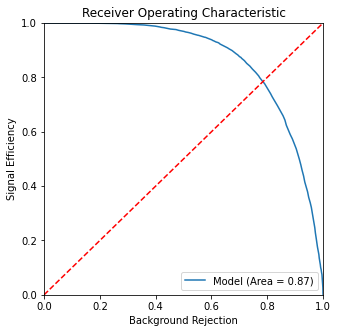

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn import metrics

def calculate_roc(pred_prob, true_labels, threshold):
  nprob = pred_prob.cpu().numpy()
  ntrue = true_labels.cpu().numpy()
  ntrue = ntrue.reshape(len(ntrue),)
  
  nfalse = [not Elem for Elem in ntrue]
  nfalse = np.array(nfalse)
  nfalse = nfalse.astype(int)

  probs = nprob[: ,1]  # index of signal  
  #print(np.shape(probs), np.shape(ntrue))

  #print(ntrue[: 10], nfalse[: 10], prob[: 10])


  mask_true_sig  = [ntrue==1]
  mask_true_sig  = mask_true_sig[0].astype(int)
  mask_true_bkgd = [ntrue==0]
  mask_true_bkgd = mask_true_bkgd[0].astype(int)

  N_sig = mask_true_sig.sum()
  N_bkgd = mask_true_bkgd.sum()

  mask = [probs>threshold]
  anti_mask = np.invert(mask)

  mask = np.asarray(mask)
  anti_mask = np.asarray(anti_mask)

  mask = mask.reshape(len(ntrue),)
  anti_mask = anti_mask.reshape(len(ntrue),)

  """
  print("probs: ", probs)
  print("mask: ", mask)
  print("anti_mask:", anti_mask)
  print("ntrue: ", ntrue)
  print("nfalse: ", nfalse)
  """
  #print("np.shape(mask), np.shape(ntrue): ", np.shape(mask), np.shape(ntrue))


  true_sig    = np.logical_and(mask,ntrue) #element wise
  true_bkgd   = np.logical_and(anti_mask,nfalse)

  tmp_S_eff = true_sig.sum()/N_sig
  tmp_B_rej = true_bkgd.sum()/N_bkgd

  #print(np.shape(true_sig), np.shape(true_bkgd))
  #print("N_sig, N_bkg: ", N_sig, N_bkgd)

  return tmp_S_eff, tmp_B_rej



Seff, Brej = calculate_roc(prob, tr_label, 0.5)

print(("cut: 0.5 eff(S): {:.2f}, rej(B): {:.2f}: ").format(Seff, Brej))


athresh = np.linspace(0.00,1.00,200)

veffs = []
vrejb = [] 

for i in range(len(athresh)):
  cut = athresh[i]
  ts, tb = calculate_roc(prob, tr_label, cut)
  #print(("cut: {:} eff(S): {:} rej(B): {:} ").format(cut, ts, tb))
  veffs.append(ts)
  vrejb.append(tb)
 
vauc = metrics.auc(veffs, vrejb)


plt.figure(figsize=(5,5))
plt.plot(veffs, vrejb, label='Model (Area = %0.2f)' % vauc) 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Background Rejection') # background rejection 
plt.ylabel('Signal Efficiency')  # signal efficiency 
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



### Plot learning curve

(10,) (10,) <class 'numpy.ndarray'>


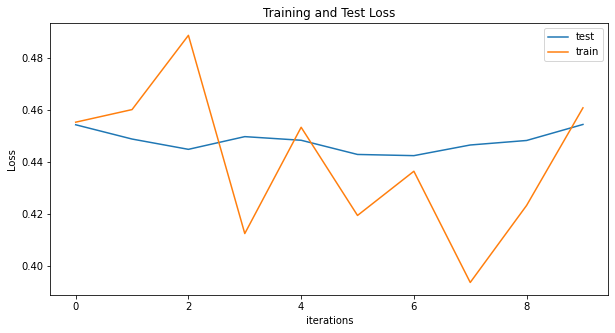

In [ ]:
def learning_curve(lres):

  train_losses = lres[2] 
  test_losses  = lres[3] 

  print(np.shape(train_losses), np.shape(test_losses), type(train_losses)) 

  plt.figure(figsize=(10,5))
  plt.title("Training and Test Loss")
  plt.plot(test_losses,label="test")
  plt.plot(train_losses,label="train")
  plt.xlabel("iterations")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

learning_curve(lres)

### BO --- Tuning Hyperparameters

In [ ]:
!pip install scikit-optimize 

     |████████████████████████████████| 100 kB 8.1 MB/s 


In [ ]:
# https://scikit-optimize.github.io/stable/auto_examples/hyperparameter-optimization.html 



from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.ensemble import GradientBoostingRegressor

def run_BO(args):



  train_loader, test_loader = load_data(args)


  # The list of hyper-parameters we want to optimize. For each one we define the
  # bounds, the corresponding scikit-learn parameter name, as well as how to
  # sample values from that dimension (`'log-uniform'` for the learning rate)
  # e.g.,
  #space  = [#Integer(1, 5, name='max_depth'),
            #Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
            #Integer(1, n_features, name='max_features'),
            #Integer(2, 100, name='min_samples_split'),
            #Integer(1, 100, name='min_samples_leaf')]


  space  = [Real(10**-5, 10**-1, "log-uniform", name='learning_rate'),
            Integer(100, 2000, "log-uniform", name='data_size')] #... change with some more meaningful hyperparameter 

  # this decorator allows your objective function to receive a the parameters as
  # keyword arguments. This is particularly convenient when you want to set
  # scikit-learn estimator parameters
  @use_named_args(space)
  def objective(**params):
      #reg.set_params(**params)

      print(params)
      print(params['learning_rate'])

      args.epochs = 2
      args.lr = params['learning_rate']
      args.dataset_size = params['data_size']
      #print(("lr: {:}, data_size: {:}").format(params['learning_rate'], params['data_size']))

      #test_loss,test_accuracy,ltrain_loss,ltest_loss = evaluate_model(args,train_loader,test_loader)
      outl = evaluate_model(args,train_loader,test_loader) 
      #return test_loss
      return outl[0]


  res_gp = gp_minimize(objective, space, n_calls=10, random_state=0) 

  return res_gp 


In [ ]:
resbo = run_BO(args)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Training on 1003 examples
Using both high and low level features
Testing on 251 examples
Using both high and low level features
{'learning_rate': 0.0023516813385771862, 'data_size': 1254}
0.0023516813385771862


Epoch 1:   0%|          | 0/2 [00:00<?, ?batch/s, loss=0.697]

Train Epoch: 1 [0/1003 (0%)]	Loss: 0.697450


Epoch 1: 100%|██████████| 2/2 [00:00<00:00,  8.63batch/s, loss=0.686]
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.6942, Accuracy: 117/251 (46.614%)



Epoch 2:  50%|█████     | 1/2 [00:00<00:00,  8.18batch/s, loss=0.448]

Train Epoch: 2 [0/1003 (0%)]	Loss: 0.708418


Epoch 2: 100%|██████████| 2/2 [00:00<00:00,  8.25batch/s, loss=0.448]



Test set: Average loss: 0.6933, Accuracy: 116/251 (46.215%)

{'learning_rate': 0.02702604344019315, 'data_size': 1266}
0.02702604344019315


Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  7.98batch/s, loss=0.625]

Train Epoch: 1 [0/1003 (0%)]	Loss: 0.702302


Epoch 1: 100%|██████████| 2/2 [00:00<00:00,  8.23batch/s, loss=0.625]



Test set: Average loss: 0.7120, Accuracy: 127/251 (50.598%)



Epoch 2:  50%|█████     | 1/2 [00:00<00:00,  8.36batch/s, loss=0.629]

Train Epoch: 2 [0/1003 (0%)]	Loss: 0.701103


Epoch 2: 100%|██████████| 2/2 [00:00<00:00,  8.42batch/s, loss=0.629]



Test set: Average loss: 0.7063, Accuracy: 128/251 (50.996%)

{'learning_rate': 0.0031207198770106443, 'data_size': 316}
0.0031207198770106443


Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  7.90batch/s, loss=0.73] 

Train Epoch: 1 [0/1003 (0%)]	Loss: 0.705493


Epoch 1: 100%|██████████| 2/2 [00:00<00:00,  8.29batch/s, loss=0.73]



Test set: Average loss: 0.6925, Accuracy: 122/251 (48.606%)



Epoch 2:  50%|█████     | 1/2 [00:00<00:00,  8.33batch/s, loss=0.784]

Train Epoch: 2 [0/1003 (0%)]	Loss: 0.699212


Epoch 2: 100%|██████████| 2/2 [00:00<00:00,  8.47batch/s, loss=0.784]



Test set: Average loss: 0.6916, Accuracy: 120/251 (47.809%)

{'learning_rate': 0.00015493103643906704, 'data_size': 119}
0.00015493103643906704


Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  8.47batch/s, loss=0.746]

Train Epoch: 1 [0/1003 (0%)]	Loss: 0.711355


Epoch 1: 100%|██████████| 2/2 [00:00<00:00,  8.43batch/s, loss=0.746]



Test set: Average loss: 0.6978, Accuracy: 124/251 (49.402%)



Epoch 2:  50%|█████     | 1/2 [00:00<00:00,  8.04batch/s, loss=0.862]

Train Epoch: 2 [0/1003 (0%)]	Loss: 0.704777


Epoch 2: 100%|██████████| 2/2 [00:00<00:00,  8.37batch/s, loss=0.862]



Test set: Average loss: 0.6978, Accuracy: 124/251 (49.402%)

{'learning_rate': 0.00012320410503562708, 'data_size': 418}
0.00012320410503562708


Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  8.16batch/s, loss=0.769]

Train Epoch: 1 [0/1003 (0%)]	Loss: 0.706479


Epoch 1: 100%|██████████| 2/2 [00:00<00:00,  8.37batch/s, loss=0.769]



Test set: Average loss: 0.6822, Accuracy: 125/251 (49.801%)



Epoch 2:  50%|█████     | 1/2 [00:00<00:00,  8.19batch/s, loss=0.477]

Train Epoch: 2 [0/1003 (0%)]	Loss: 0.696793


Epoch 2: 100%|██████████| 2/2 [00:00<00:00,  8.39batch/s, loss=0.477]



Test set: Average loss: 0.6821, Accuracy: 125/251 (49.801%)

{'learning_rate': 0.017728619337514944, 'data_size': 421}
0.017728619337514944


Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  8.35batch/s, loss=0.713]

Train Epoch: 1 [0/1003 (0%)]	Loss: 0.706036


Epoch 1: 100%|██████████| 2/2 [00:00<00:00,  8.50batch/s, loss=0.713]



Test set: Average loss: 0.6931, Accuracy: 116/251 (46.215%)



Epoch 2:  50%|█████     | 1/2 [00:00<00:00,  8.30batch/s, loss=0.693]

Train Epoch: 2 [0/1003 (0%)]	Loss: 0.702767


Epoch 2: 100%|██████████| 2/2 [00:00<00:00,  8.48batch/s, loss=0.693]



Test set: Average loss: 0.7098, Accuracy: 128/251 (50.996%)

{'learning_rate': 0.0003725110709391402, 'data_size': 1224}
0.0003725110709391402


Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  8.12batch/s, loss=0.693]

Train Epoch: 1 [0/1003 (0%)]	Loss: 0.691911


Epoch 1: 100%|██████████| 2/2 [00:00<00:00,  8.33batch/s, loss=0.693]



Test set: Average loss: 0.6865, Accuracy: 142/251 (56.574%)



Epoch 2:  50%|█████     | 1/2 [00:00<00:00,  7.97batch/s, loss=0.593]

Train Epoch: 2 [0/1003 (0%)]	Loss: 0.698491


Epoch 2: 100%|██████████| 2/2 [00:00<00:00,  8.25batch/s, loss=0.593]



Test set: Average loss: 0.6864, Accuracy: 141/251 (56.175%)

{'learning_rate': 0.00022365810539197545, 'data_size': 697}
0.00022365810539197545


Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  8.45batch/s, loss=0.618]

Train Epoch: 1 [0/1003 (0%)]	Loss: 0.701276


Epoch 1: 100%|██████████| 2/2 [00:00<00:00,  8.61batch/s, loss=0.618]



Test set: Average loss: 0.7011, Accuracy: 128/251 (50.996%)



Epoch 2:  50%|█████     | 1/2 [00:00<00:00,  7.59batch/s, loss=0.714]

Train Epoch: 2 [0/1003 (0%)]	Loss: 0.695933


Epoch 2: 100%|██████████| 2/2 [00:00<00:00,  8.13batch/s, loss=0.714]



Test set: Average loss: 0.7010, Accuracy: 126/251 (50.199%)

{'learning_rate': 0.0002971434485724498, 'data_size': 1759}
0.0002971434485724498


Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  8.47batch/s, loss=0.747]

Train Epoch: 1 [0/1003 (0%)]	Loss: 0.698869


Epoch 1: 100%|██████████| 2/2 [00:00<00:00,  8.68batch/s, loss=0.747]



Test set: Average loss: 0.6950, Accuracy: 128/251 (50.996%)



Epoch 2:  50%|█████     | 1/2 [00:00<00:00,  7.81batch/s, loss=0.786]

Train Epoch: 2 [0/1003 (0%)]	Loss: 0.701549


Epoch 2: 100%|██████████| 2/2 [00:00<00:00,  8.29batch/s, loss=0.786]



Test set: Average loss: 0.6949, Accuracy: 127/251 (50.598%)

{'learning_rate': 3.642529868570471e-05, 'data_size': 1355}
3.642529868570471e-05


Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  7.95batch/s, loss=0.752]

Train Epoch: 1 [0/1003 (0%)]	Loss: 0.705041


Epoch 1: 100%|██████████| 2/2 [00:00<00:00,  8.33batch/s, loss=0.752]



Test set: Average loss: 0.6933, Accuracy: 121/251 (48.207%)



Epoch 2:  50%|█████     | 1/2 [00:00<00:00,  8.01batch/s, loss=0.727]

Train Epoch: 2 [0/1003 (0%)]	Loss: 0.700006


Epoch 2: 100%|██████████| 2/2 [00:00<00:00,  8.39batch/s, loss=0.727]



Test set: Average loss: 0.6933, Accuracy: 121/251 (48.207%)



Best score= 0.6821, optimal point: [0.00012320410503562708, 418]


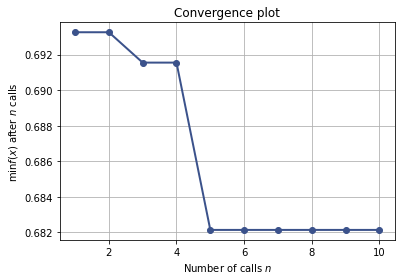

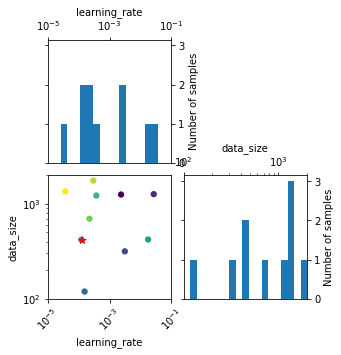

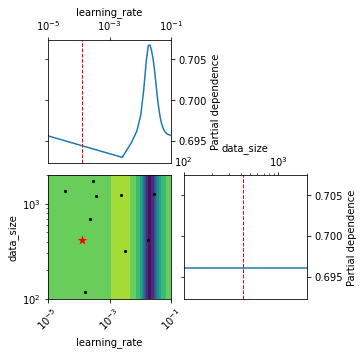

In [ ]:
# https://scikit-optimize.github.io/stable/auto_examples/hyperparameter-optimization.html 

from skopt.plots import plot_convergence
from skopt.plots import plot_objective
from skopt.plots import plot_evaluations

#--------------------------------------#
#----------- visualization ------------#
#--------------------------------------#

plot_convergence(resbo)

_ = plot_evaluations(resbo)
_ = plot_objective(resbo)


print(("Best score= {:.4f}, optimal point: {:}").format(resbo.fun, resbo.x))
#print(resbo)

### Inference phase with optimized parameters

In [ ]:
args.epochs = 2
args.lr = resbo.x[0]
args.dataset_size = resbo.x[1]

print(args)

#test_loss,test_accuracy,ltrain_loss,ltest_loss = evaluate_model(args,train_loader,test_loader)




Namespace(batch_size=1000, dataset_size=418, epochs=2, high_level_feats=None, log_interval=10, lr=0.00012320410503562708, momentum=0.8, no_cuda=True, seed=2, test_batch_size=1000)


### ROC curve and data selection 

In [ ]:
# load data 

#print(np.shape(test_loss))
"""
args.dataset_size=100000
args.batch_size=int(dataset_size)

# load data
train_loader, test_loader = load_data(args)


#tmpy_prob = DNN.predict_proba(X_test)[:,1] 
"""

'\nargs.dataset_size=100000\nargs.batch_size=int(dataset_size)\n\n# load data\ntrain_loader, test_loader = load_data(args)\n\n\n#tmpy_prob = DNN.predict_proba(X_test)[:,1] \n'

### Extract weights of your model

In [ ]:
# https://pytorch.org/tutorials/beginner/saving_loading_models.html

# https://stackoverflow.com/questions/56435961/how-to-access-the-network-weights-while-using-pytorch-nn-sequential 

### Model Summary


In [ ]:
from torchsummary import summary

"""
your_model = 
channels = 1 
H = 1
W = 18
summary(your_model, input_size=(channels, H, W))
"""

'\nyour_model = \nchannels = 1 \nH = 1\nW = 18\nsummary(your_model, input_size=(channels, H, W))\n'